In [1]:
import keras
import pdb
import gc
import requests

In [2]:
!pip install --upgrade pip
!pip install mat73
!pip install scikit-learn --upgrade
!pip install scipy
!pip install Bayesian-Optimization
!pip install fpdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
import mat73
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import statistics as st
from fpdf import FPDF
import cv2

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pdf = FPDF()
dataset = mat73.loadmat('/content/drive/MyDrive/CNN_Chagas/Chagas/data/Dataset_Raw.mat')

In [6]:
signals = list(dataset['Dataset_Raw'])

output = []
for i in range(0, len(signals)):
    output.append(signals[i][-1])
    signals[i] = np.delete(signals[i], [-1,-2])
    # signals[i] = signals[i][0:1000]

In [7]:
def discrete_ratio(ratio_set, n):
    classes = list(range(1, n+1))
    ratio = 1.0/n
    
    for j in range(0, len(ratio_set)):
        for i in range(0, n):
            if ratio_set[j] > ratio*i and ratio_set[j] <= ratio*(i+1):
                ratio_set[j] = int(classes[i])
                break
                
    return ratio_set

In [8]:
output = discrete_ratio(output, 2)

In [9]:
with open('Sinais_Chagas.txt') as f:
    lines = f.readlines()

idx = []

for i in range(0, len(lines)):
  arq = lines[i][lines[i].find('FileName1 = '):lines[i].find('\n')]
  signal = lines[i][lines[i].find('Signals{'):lines[i].find('\n')]
  signal = signal[signal.find('{')+1 : signal.find('}')]

  if arq != '':
    idx.append(arq[13:-2])
  if signal != '':
     idx.append(signal)
  
idx = idx[:-3]


pairs = []
for i in range(0, len(idx), 2):
  val = [idx[i+1], idx[i]]
  pairs.append(val)

In [10]:
matriz_pontos = []
for i in pairs:
    url =  str(i[1]) + '_MatrizPontos.mat'
    pontos = sio.loadmat(url)
    matriz_pontos.append(pontos["Matriz_Pontos"])

In [11]:
peaks = []
for sig in matriz_pontos:
  line = []
  for beat in sig:
    line.append(beat[4])
  peaks.append(line)  

## Wavelet transform

In [12]:
def gera_filtro_MH(Escala):
  passo = 1/Escala
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro, mode='same')
  return y

In [13]:
x = []
for i in signals:
  val = apply_wavelet(i, 2**2)
  x.append(val)

signals = x
del x

## Data Split

In [14]:
x_rem, x_te, p_rem, p_te, y_rem, y_te = train_test_split(signals, peaks, output, test_size=0.15, stratify=output, random_state=38)
x_tr, x_va, p_tr, p_va, y_tr, y_va = train_test_split(x_rem, p_rem, y_rem, test_size=0.15, stratify=y_rem, random_state=38)

## Medium beats acquisition

In [15]:
def signals_med(array):
    array_size = len(array[0])
    array_qnt = len(array)
    md_vector = []

    for j in range(0, array_size):
        aux = []

        for i in range(0, array_qnt):
            aux.append(array[i][j])
        
        md_vector.append(st.median(aux))

    return md_vector

In [16]:
def shifting(signal, samples_position, beat_template):
  samples = []
  shift = 10
  for p_index, p in enumerate(samples_position):
    aux = []
    for i in range(-1*shift, shift+1):
      aux.apppend(mean_squared_error(beat_template, signal[p[0]+i:p[1]+i]))

    M = aux.index(min(aux)) - shift
    samples_position[p_index] = [p[0]+M, p[1]+M]
    samples.append(signal[p[0]+M : p[1]+M])
  

  return samples_position, samples


In [17]:
def del_var(samples, samples_position, beat_template):
  
    for idx, sample in enumerate(samples):
        val = 0
        for i in range (len(sample)):
            val += (sample[i] - beat_template[i])**2
            
        val /= len(sample)

        if val > st.variance(beat_template):
            samples.pop(idx)
            samples_position.pop(idx)

    return samples_position, samples 

In [18]:
def window(signal, peaks):
    #calculating L
    peaks_difference = [peaks[i+1] - peaks[i] for i in range(len(peaks)-1)]
    L = 1.1*st.median(peaks_difference)
    
    #obtening beat samples
    #samples position consists in an array of tuples. Each tuples contains the estimate begin and end of a beat
    samples_position = []
    samples = []

    # pdb.set_trace()
    for idx, p in enumerate(peaks):
        samples.append(signal[p-math.floor(L/3) : p+math.ceil(2*L/3)])
        samples_position.append([p-math.floor(L/3) , p+math.ceil(2*L/3)])
 
    beat_template = signals_med(samples)
    variance = st.variance(beat_template)
    # samples_position, samples = shifting(signal, samples_position, beat_template)
    # samples_position, samples = del_var(samples, beat_template)

    return variance, beat_template

In [19]:
del dataset, signal, matriz_pontos

In [20]:
bps = 50

In [21]:
def medium_beats_acquisition(signal, peaks, output, bps):
  templates = []
  classes = []
  variance = []
  for idx, p in enumerate(peaks):
      for i in range(0, len(p)-bps, bps):
          var, beats_t = window(signals[idx], p[i:i+bps])
          if var > 0:
            templates.append(beats_t)
            classes.append(output[idx])
            variance.append(var)

  return variance, templates, classes
  

In [22]:
vtr, x_train, y_train = medium_beats_acquisition(x_tr, p_tr, y_tr, bps)
vva, x_valid, y_valid = medium_beats_acquisition(x_va, p_va, y_va, bps)
vte, x_test, y_test = medium_beats_acquisition(x_te, p_te, y_te, bps)

In [23]:
count = 0
for i in vtr+vva+vte:
  if i == 0:
    count+=1
print(count)

0


In [24]:
def get_max_size(vec):
    maximum = len(max(vec, key = len))
    return maximum

In [25]:
lim= get_max_size(x_train + x_valid + x_test)

In [26]:
def norm_len_2(s, lsup):

    for i, beat in enumerate(s):
      n = math.floor(lsup) - len(beat)

      zeros = np.zeros(int(n))
      s[i] = np.concatenate((beat, zeros), axis=None)

    return s

In [27]:
x_valid = norm_len_2(x_valid, lim)
x_train = norm_len_2(x_train, lim)
x_test = norm_len_2(x_test, lim)

In [28]:
y_valid = pd.get_dummies(y_valid)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [29]:
x_train = np.array(list(x_train))
x_valid = np.array(list(x_valid))
x_test = np.array(list(x_test))

In [30]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], -1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], -1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], -1)

In [31]:
x_valid.shape

(4650, 297, 1)

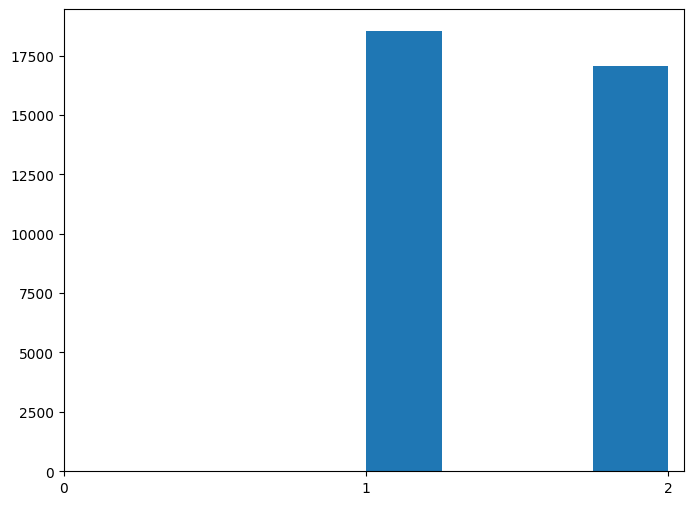

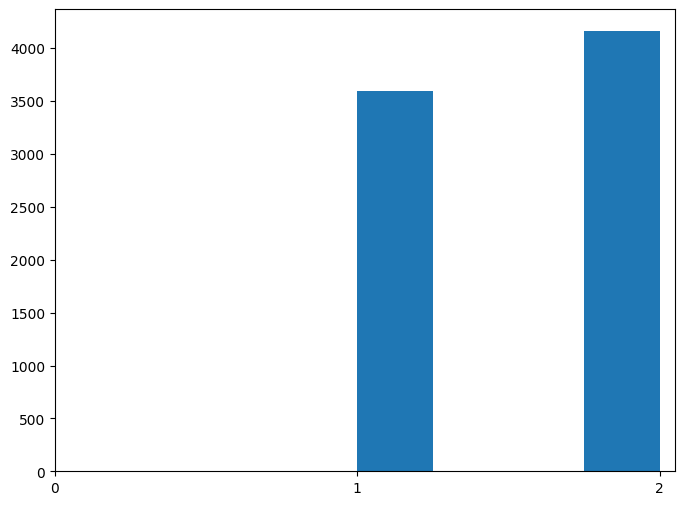

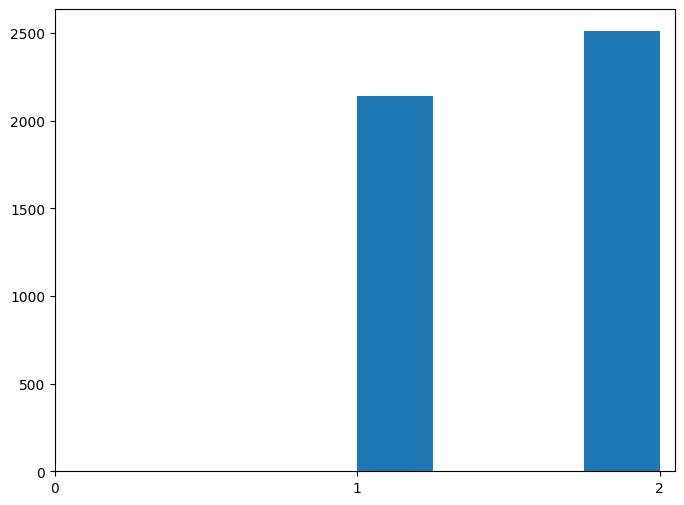

In [32]:
for i in [y_train, y_test, y_valid]:
  i.idxmax(axis=1).hist(
    figsize=(8, 6),
    range = [1, 2],
    grid = False,
    bins = 4,
  )
  plt.xticks(range(3))
  plt.show()

In [33]:
inp_shape = (x_train.shape[1], 1)

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, concatenate
from keras.layers import Conv1D, Conv2D, LSTM,  Bidirectional
from bayes_opt import BayesianOptimization

from keras.layers import Dense, BatchNormalization, Dropout, MaxPooling1D,  MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl



from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn import metrics

from sklearn import metrics
import tensorflow as tf

In [35]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [36]:
def network(lstm_layers, dense_layers, units, neurons_ini, optimizer, learning_rate, dropout):
    
    classificador_1 = Sequential()

    for i in range(lstm_layers):
        if i == 0:
            classificador_1.add(Bidirectional(LSTM(units=units, return_sequences = True,  activation='tanh',
                                     recurrent_activation='sigmoid', recurrent_dropout=0, input_shape=inp_shape)))
        else:    
            classificador_1.add(Bidirectional(LSTM(units=units, return_sequences = True,  activation='tanh',
                                     recurrent_activation='sigmoid', recurrent_dropout=0)))

    classificador_1.add(Flatten())

    for i in range(dense_layers):
        classificador_1.add(Dense(neurons_ini, activation='relu'))
        classificador_1.add(Dropout(dropout))
        neurons_ini = neurons_ini/2

    classificador_1.add(Dense(2, activation='softmax'))

    classificador_1.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=learning_rate), metrics=["accuracy"])

    return classificador_1

In [37]:
def evaluate_network(batch_size , dense_layers,  dropout  , learning_rate , lstm_layers , neurons_ini , optimizer ,   units):
    
    global y_valid
        
    
    lstm_layers = round(lstm_layers)
    dense_layers = round(dense_layers)
    units = 20*round(units)
    neurons_ini = 2**round(neurons_ini)
    optimizer = round(optimizer)
    batch_size = 2**round(batch_size)
    learning_rate = round(learning_rate)
    print(learning_rate)

    optimizer_array = [Adam, RMSprop, Adadelta, Adagrad, Adamax,SGD]
    optimizer_val = optimizer_array[optimizer]
    
    learn_array = [0.1, 0.01]
    learn_val = learn_array[learning_rate]

    model = network(lstm_layers, dense_layers, units, neurons_ini, optimizer_val, learn_val, dropout)
    
    es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=15)

    checkpoint = ModelCheckpoint('_pesos_lstm1.h5', monitor="val_accuracy", verbose=0, 
                                      save_best_only=True, mode='max') 

    history_1 = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
                                    epochs=150, batch_size = batch_size, callbacks=[es, checkpoint],
                                    verbose=0, use_multiprocessing=True, workers=8)
    
    model = load_model('_pesos_lstm1.h5')
    
    #plot history
    plt.rcParams['figure.figsize']=(20,5)
    plt.rcParams.update({'font.size': 20})

    plt.plot(history_1.history['accuracy'])
    plt.plot(history_1.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    #plt.savefig("history.png")
    plt.show()

    #predict
    y_pred = model.predict(x_test)
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = [1, 2]
    y_pred = y_pred.idxmax(axis=1)
    y_te = y_test.idxmax(axis=1)

    #plot confusion matrix
    plt.rcParams['figure.figsize']=(2,2)
    plt.rcParams.update({'font.size': 10})

    cf_matrix = confusion_matrix(y_te, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
    cm_display.plot()
    #cm_display.figure_.savefig("cf_matrix.png")
    plt.show()

    #display report
    relatorio = classification_report(y_te, y_pred, target_names = ['1','2']) 
    print(relatorio)

    #calculating score
    y_pred = model.predict(x_valid)
    y_pred = (np.asarray(y_pred)).round()
    y_pred = y_pred.astype(int)
    y_val = np.array(y_valid)

    score = accuracy_score(y_val, y_pred)

    #add information to pdf
    # image1 = cv2.imread("history.png")
    # image2 = cv2.imread("cf_matrix.png")
    # pdf.add_page()
    # pdf.image(image1)
    # pdf.image(image2)
    # pdf.cell(txt=relatorio)



    return score

In [38]:
# pdf.output("yourfile.pdf", "F")

|   iter    |  target   | batch_... | dense_... |  dropout  | learni... | lstm_l... | neuron... | optimizer |   units   |
-------------------------------------------------------------------------------------------------------------------------
0


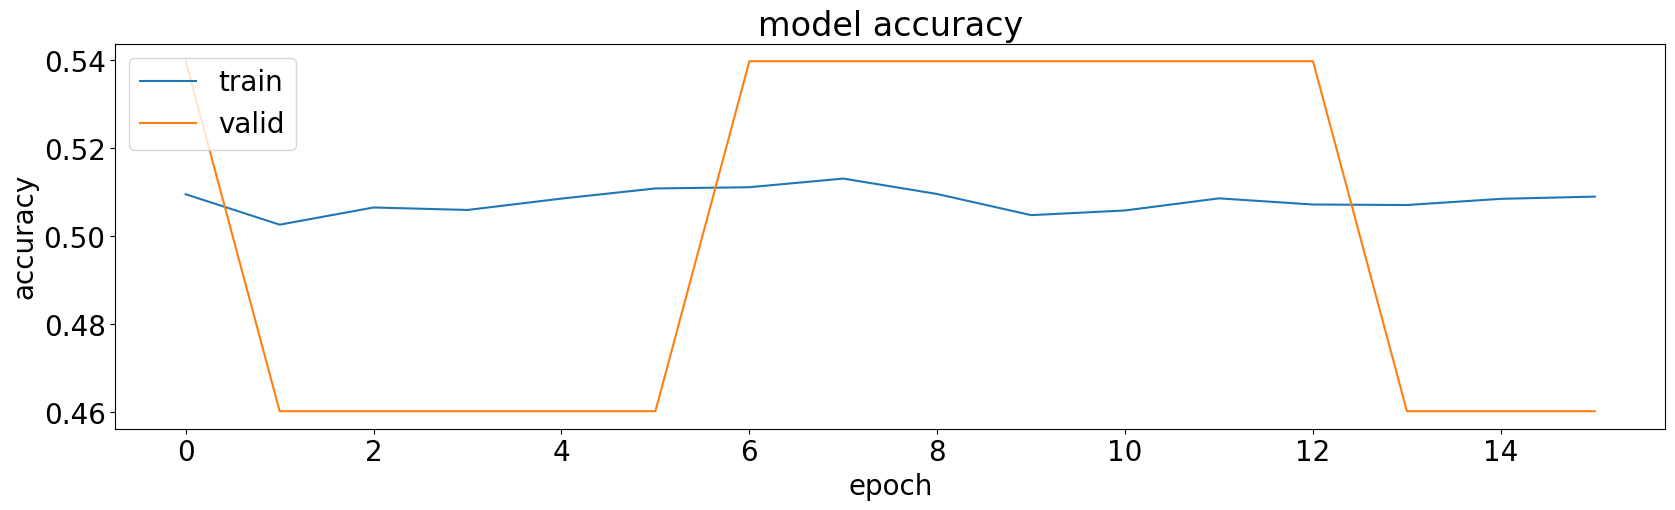

243/243 [==============================] - 6s 23ms/step


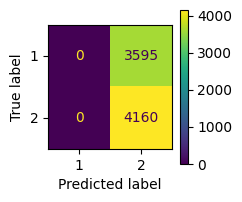

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3595
           2       0.54      1.00      0.70      4160

    accuracy                           0.54      7755
   macro avg       0.27      0.50      0.35      7755
weighted avg       0.29      0.54      0.37      7755

146/146 [==============================] - 2s 15ms/step
| 1         | 0.5398    | 7.251     | 3.161     | 0.3       | 0.3023    | 1.44      | 5.185     | 0.9313    | 4.728     |
1


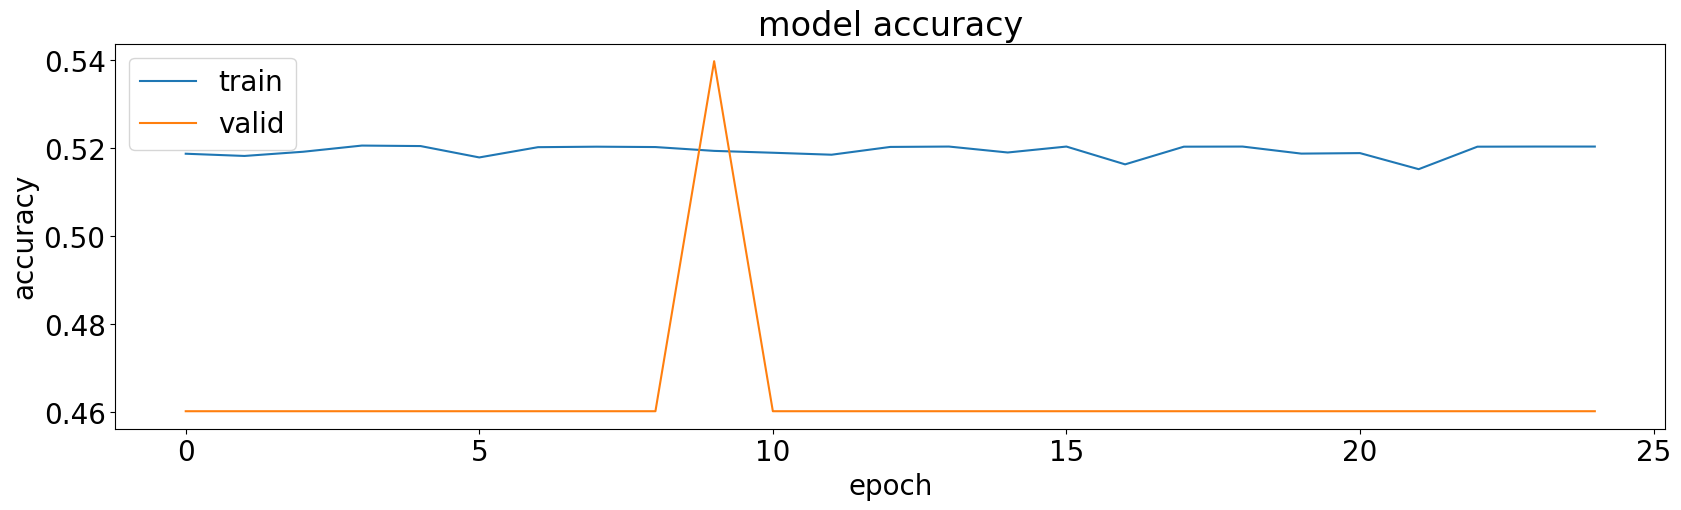

243/243 [==============================] - 10s 34ms/step


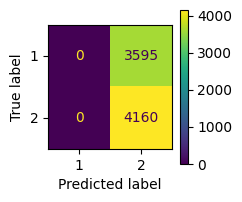

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3595
           2       0.54      1.00      0.70      4160

    accuracy                           0.54      7755
   macro avg       0.27      0.50      0.35      7755
weighted avg       0.29      0.54      0.37      7755

146/146 [==============================] - 3s 19ms/step
| 2         | 0.5398    | 7.19      | 2.616     | 0.4258    | 0.6852    | 1.613     | 6.756     | 0.1369    | 6.352     |
0


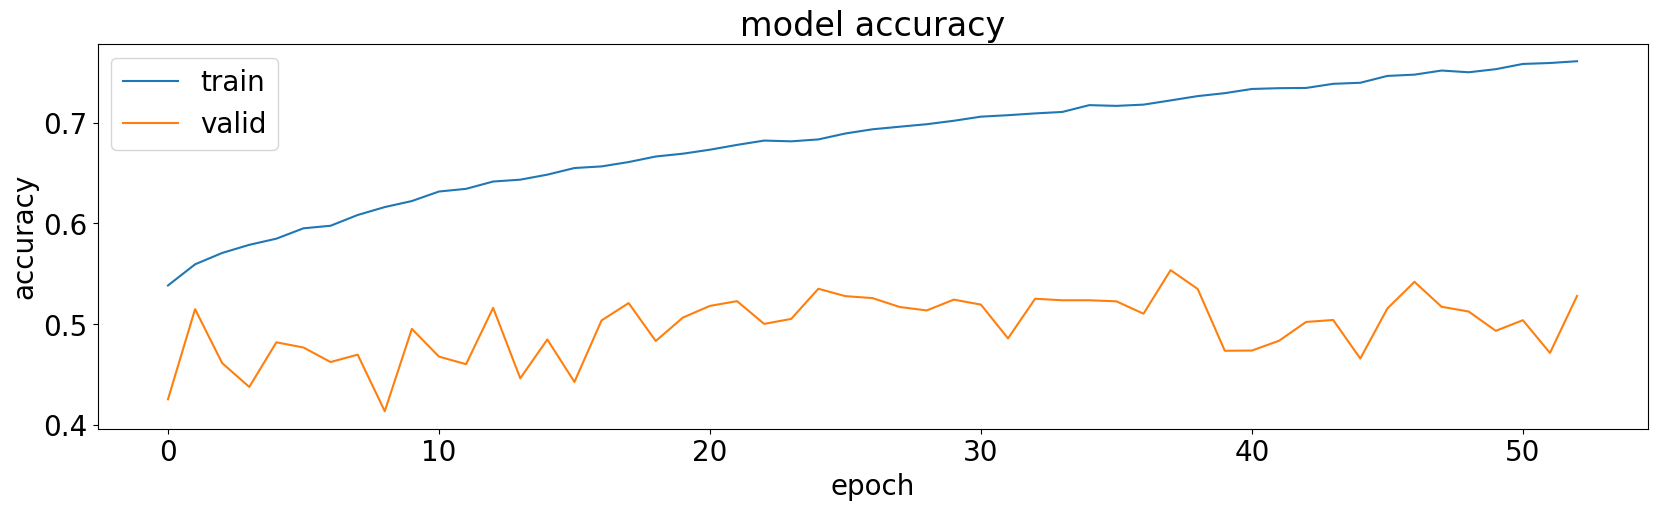

243/243 [==============================] - 11s 39ms/step


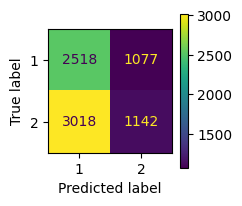

              precision    recall  f1-score   support

           1       0.45      0.70      0.55      3595
           2       0.51      0.27      0.36      4160

    accuracy                           0.47      7755
   macro avg       0.48      0.49      0.45      7755
weighted avg       0.49      0.47      0.45      7755

146/146 [==============================] - 6s 41ms/step
| 3         | 0.5535    | 7.252     | 2.676     | 0.3421    | 0.1981    | 3.402     | 6.937     | 1.567     | 6.462     |
0


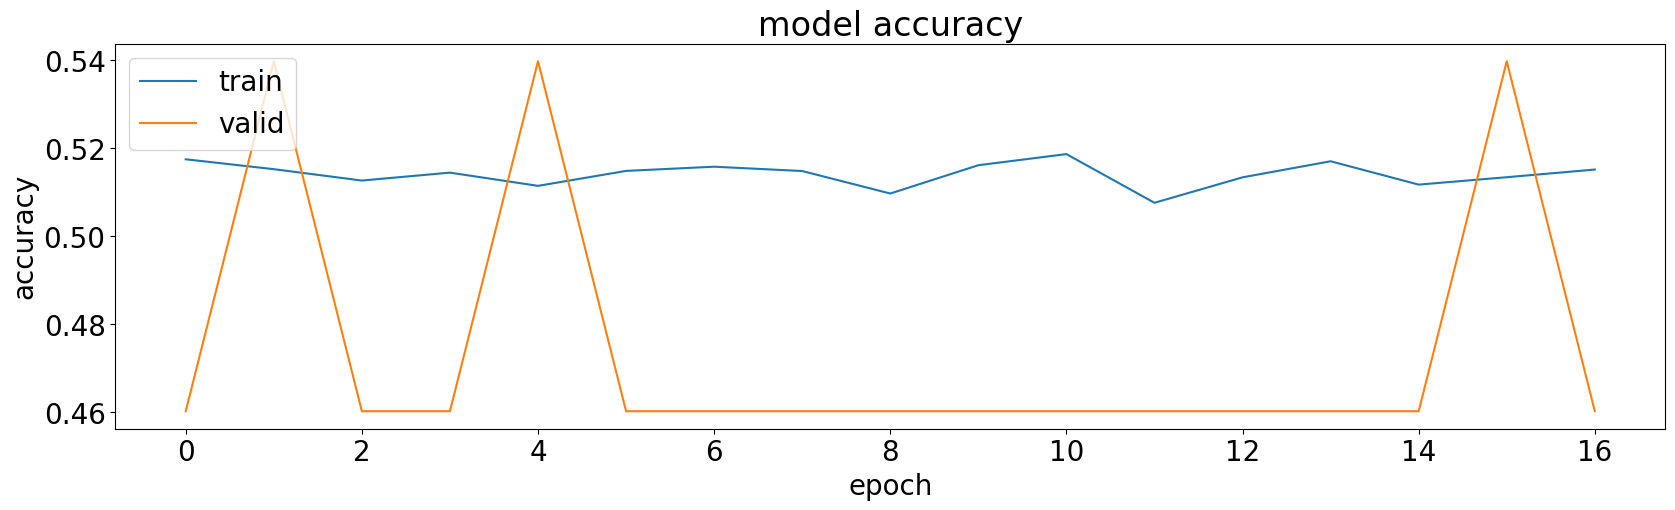

243/243 [==============================] - 9s 31ms/step


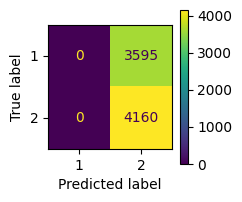

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3595
           2       0.54      1.00      0.70      4160

    accuracy                           0.54      7755
   macro avg       0.27      0.50      0.35      7755
weighted avg       0.29      0.54      0.37      7755

146/146 [==============================] - 5s 31ms/step
| 4         | 0.5398    | 8.629     | 3.684     | 0.3255    | 0.03905   | 1.509     | 6.756     | 0.4917    | 5.106     |
0


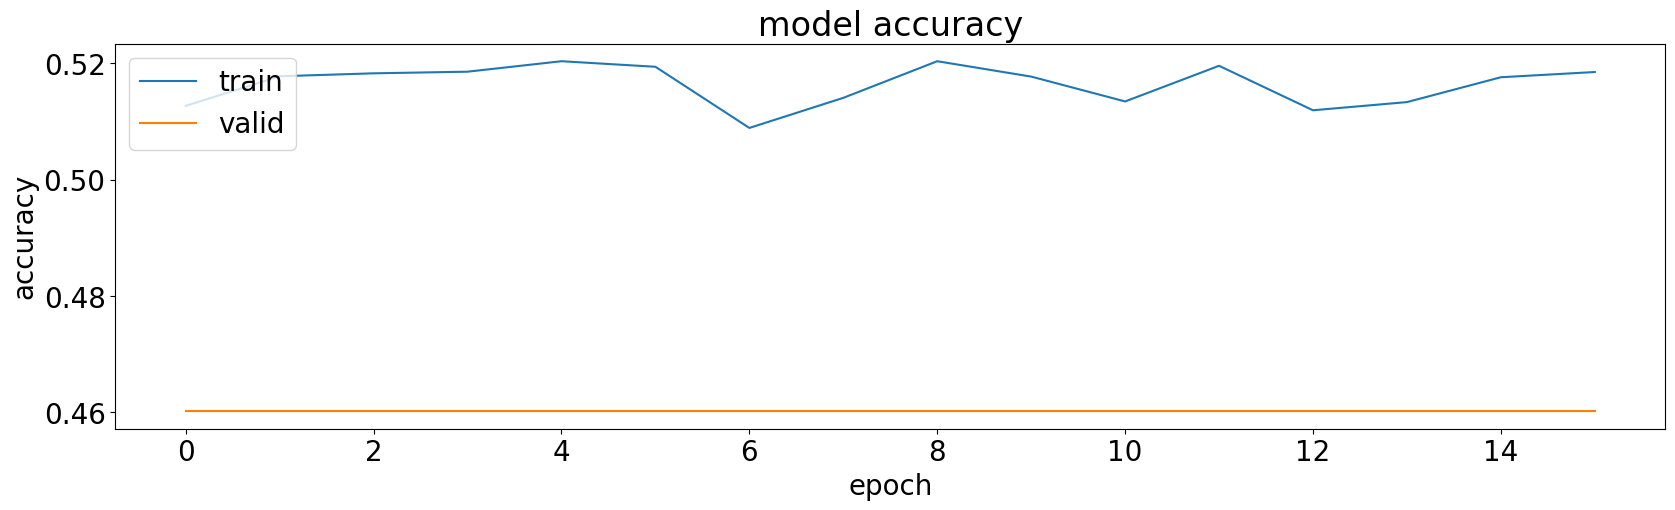

243/243 [==============================] - 11s 39ms/step


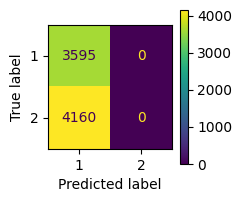

              precision    recall  f1-score   support

           1       0.46      1.00      0.63      3595
           2       0.00      0.00      0.00      4160

    accuracy                           0.46      7755
   macro avg       0.23      0.50      0.32      7755
weighted avg       0.21      0.46      0.29      7755

146/146 [==============================] - 8s 55ms/step
| 5         | 0.4602    | 8.874     | 2.599     | 0.5076    | 0.3155    | 3.06      | 6.669     | 0.09144   | 6.751     |
1


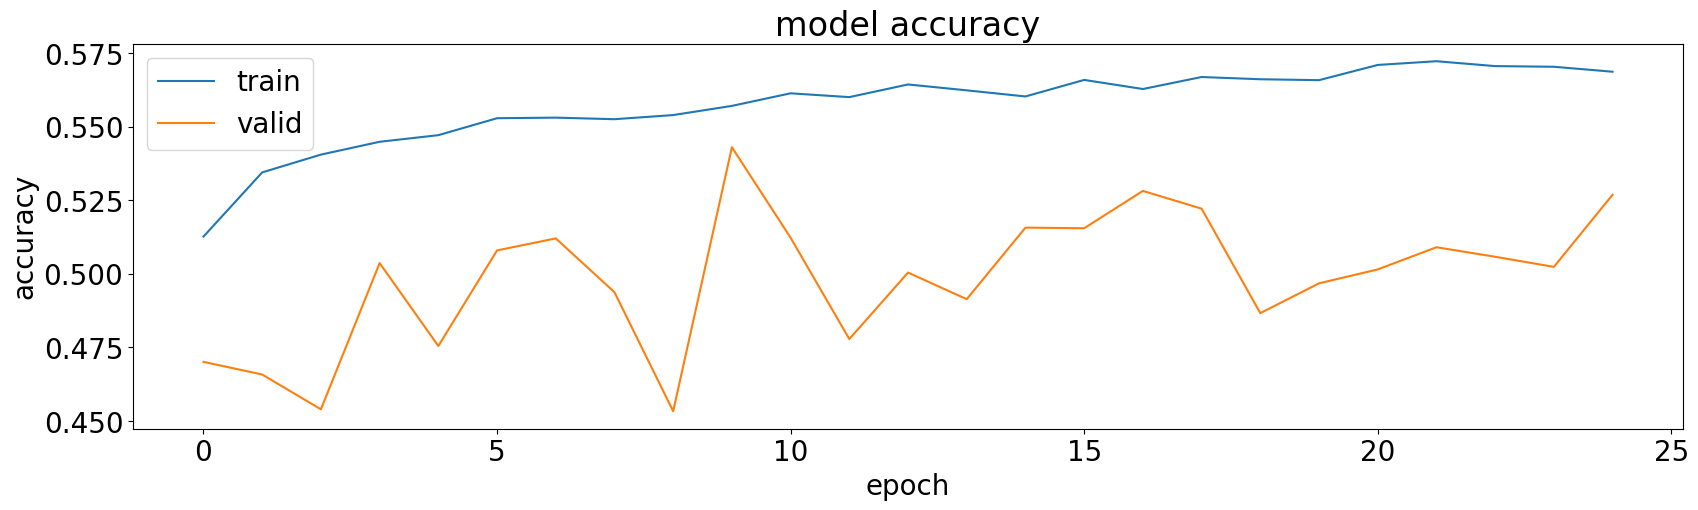

243/243 [==============================] - 4s 14ms/step


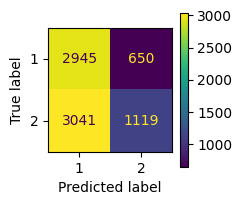

              precision    recall  f1-score   support

           1       0.49      0.82      0.61      3595
           2       0.63      0.27      0.38      4160

    accuracy                           0.52      7755
   macro avg       0.56      0.54      0.50      7755
weighted avg       0.57      0.52      0.49      7755

146/146 [==============================] - 2s 14ms/step
| 6         | 0.543     | 8.967     | 3.244     | 0.3841    | 0.7893    | 1.31      | 5.896     | 4.543     | 4.468     |
1


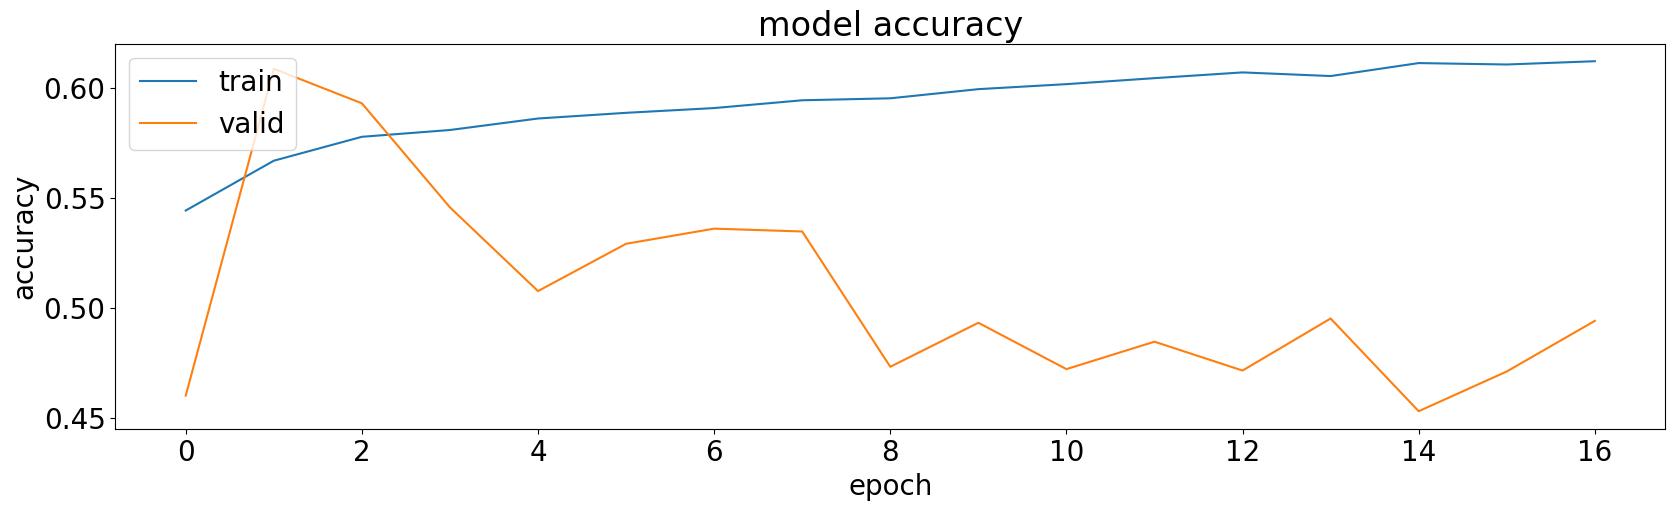

243/243 [==============================] - 8s 28ms/step


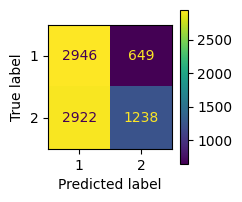

              precision    recall  f1-score   support

           1       0.50      0.82      0.62      3595
           2       0.66      0.30      0.41      4160

    accuracy                           0.54      7755
   macro avg       0.58      0.56      0.52      7755
weighted avg       0.58      0.54      0.51      7755

146/146 [==============================] - 3s 19ms/step
| 7         | 0.6086    | 6.863     | 1.39      | 0.3058    | 0.6788    | 1.635     | 5.531     | 2.458     | 3.267     |
1


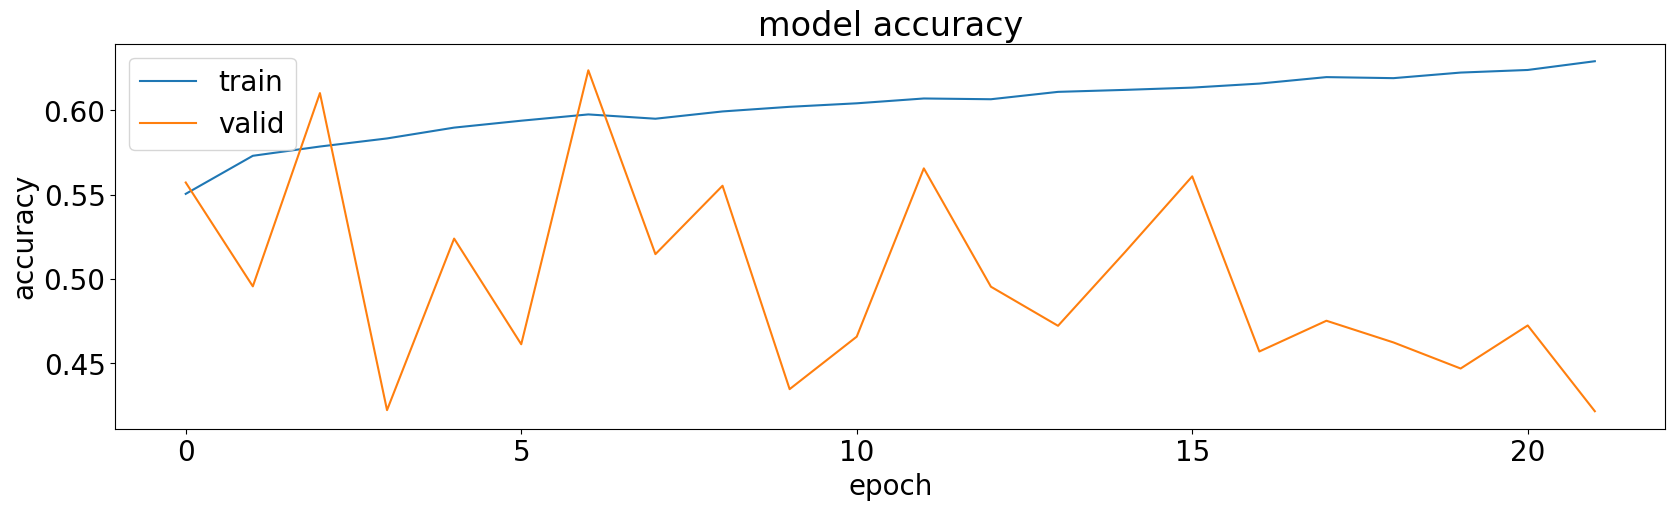

243/243 [==============================] - 4s 13ms/step


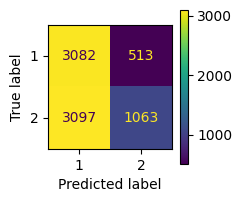

              precision    recall  f1-score   support

           1       0.50      0.86      0.63      3595
           2       0.67      0.26      0.37      4160

    accuracy                           0.53      7755
   macro avg       0.59      0.56      0.50      7755
weighted avg       0.59      0.53      0.49      7755

146/146 [==============================] - 3s 19ms/step
| 8         | 0.6239    | 7.722     | 1.44      | 0.4768    | 0.6998    | 1.307     | 5.828     | 3.472     | 5.071     |
1


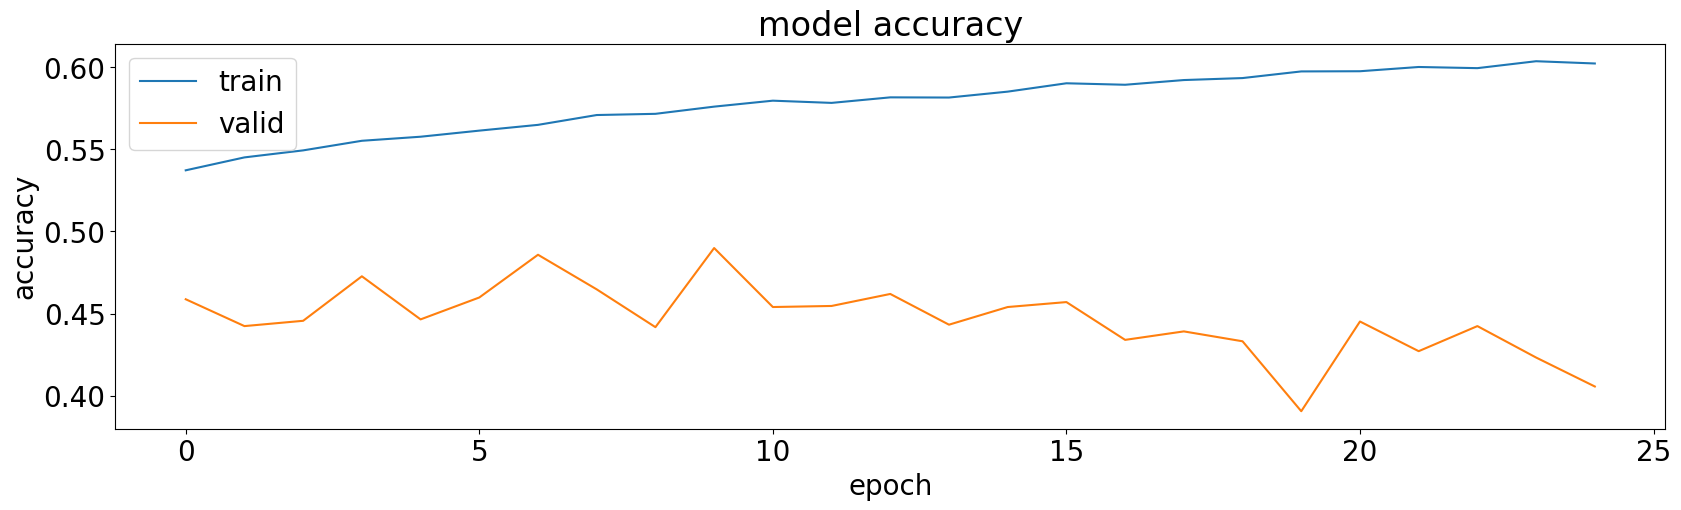

243/243 [==============================] - 18s 65ms/step


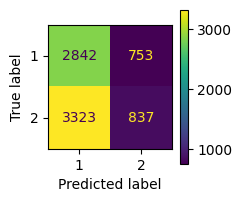

              precision    recall  f1-score   support

           1       0.46      0.79      0.58      3595
           2       0.53      0.20      0.29      4160

    accuracy                           0.47      7755
   macro avg       0.49      0.50      0.44      7755
weighted avg       0.50      0.47      0.43      7755

146/146 [==============================] - 8s 57ms/step
| 9         | 0.4899    | 6.15      | 2.608     | 0.4991    | 0.5149    | 3.834     | 6.173     | 4.517     | 3.687     |
0


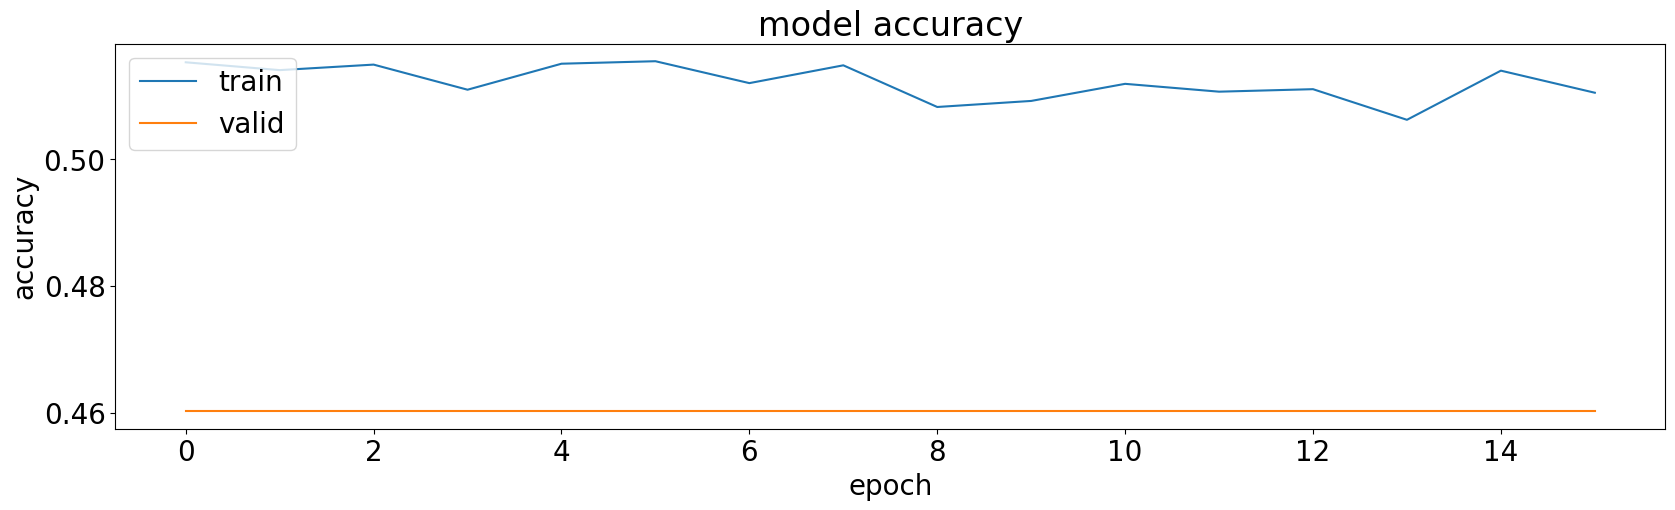

243/243 [==============================] - 21s 76ms/step


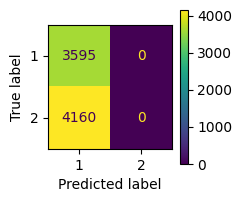

              precision    recall  f1-score   support

           1       0.46      1.00      0.63      3595
           2       0.00      0.00      0.00      4160

    accuracy                           0.46      7755
   macro avg       0.23      0.50      0.32      7755
weighted avg       0.21      0.46      0.29      7755

146/146 [==============================] - 11s 77ms/step
| 10        | 0.4602    | 6.418     | 3.422     | 0.4193    | 0.1654    | 3.783     | 5.696     | 3.754     | 6.63      |
0


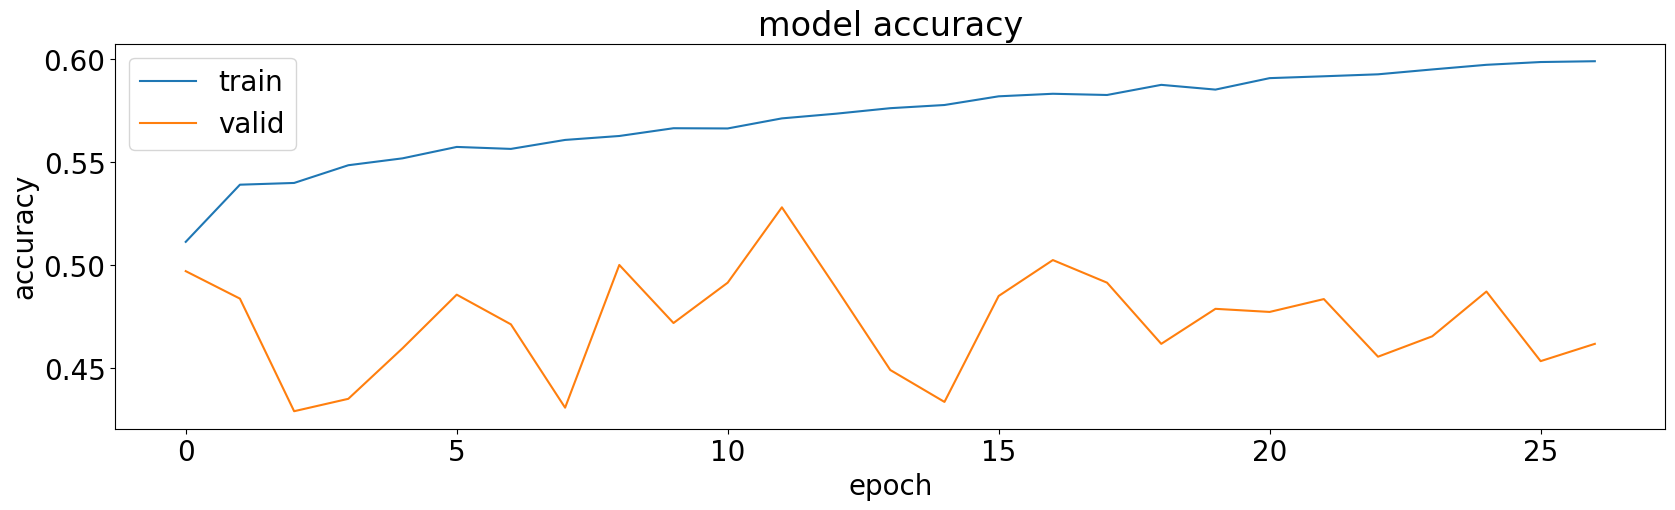

243/243 [==============================] - 11s 40ms/step


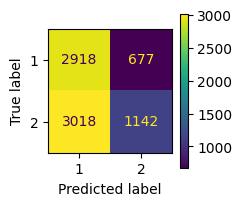

              precision    recall  f1-score   support

           1       0.49      0.81      0.61      3595
           2       0.63      0.27      0.38      4160

    accuracy                           0.52      7755
   macro avg       0.56      0.54      0.50      7755
weighted avg       0.56      0.52      0.49      7755

146/146 [==============================] - 6s 42ms/step
| 11        | 0.5282    | 8.65      | 2.871     | 0.5253    | 0.3489    | 1.81      | 6.792     | 2.14      | 7.824     |
1


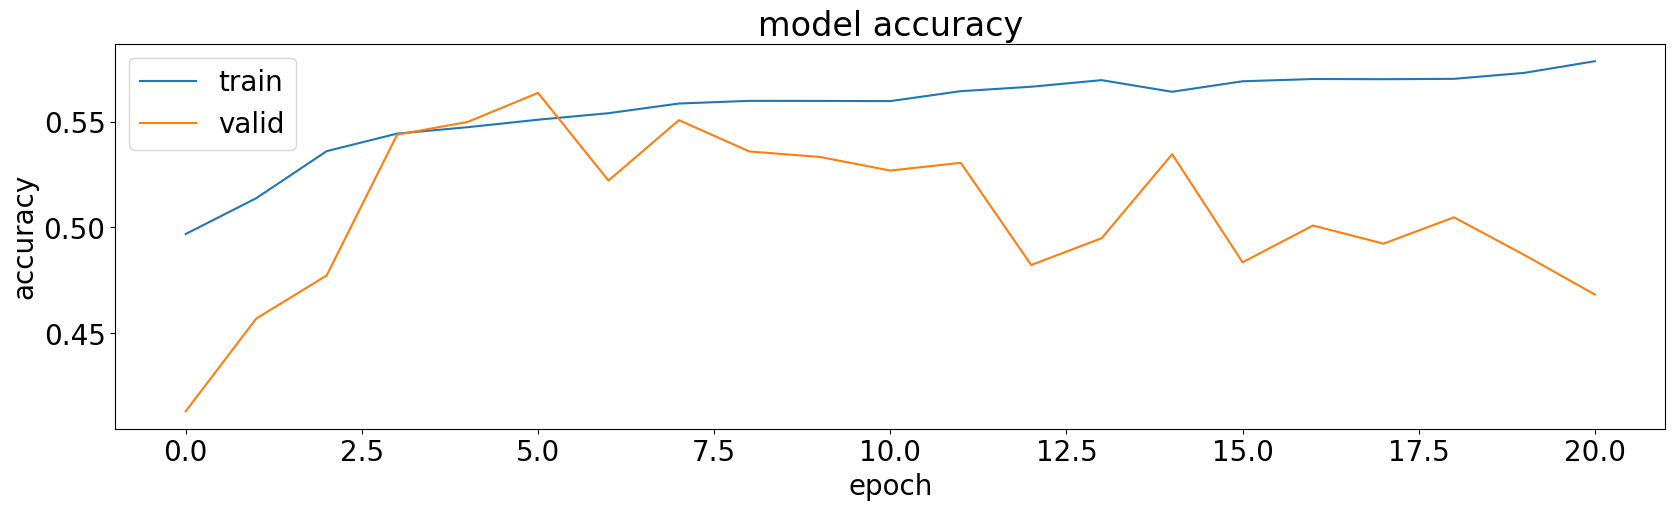

243/243 [==============================] - 10s 37ms/step


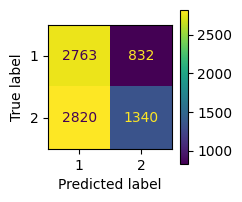

              precision    recall  f1-score   support

           1       0.49      0.77      0.60      3595
           2       0.62      0.32      0.42      4160

    accuracy                           0.53      7755
   macro avg       0.56      0.55      0.51      7755
weighted avg       0.56      0.53      0.51      7755

146/146 [==============================] - 5s 34ms/step
| 12        | 0.5637    | 7.99      | 2.865     | 0.3344    | 0.9495    | 2.35      | 6.157     | 2.041     | 4.185     |
1


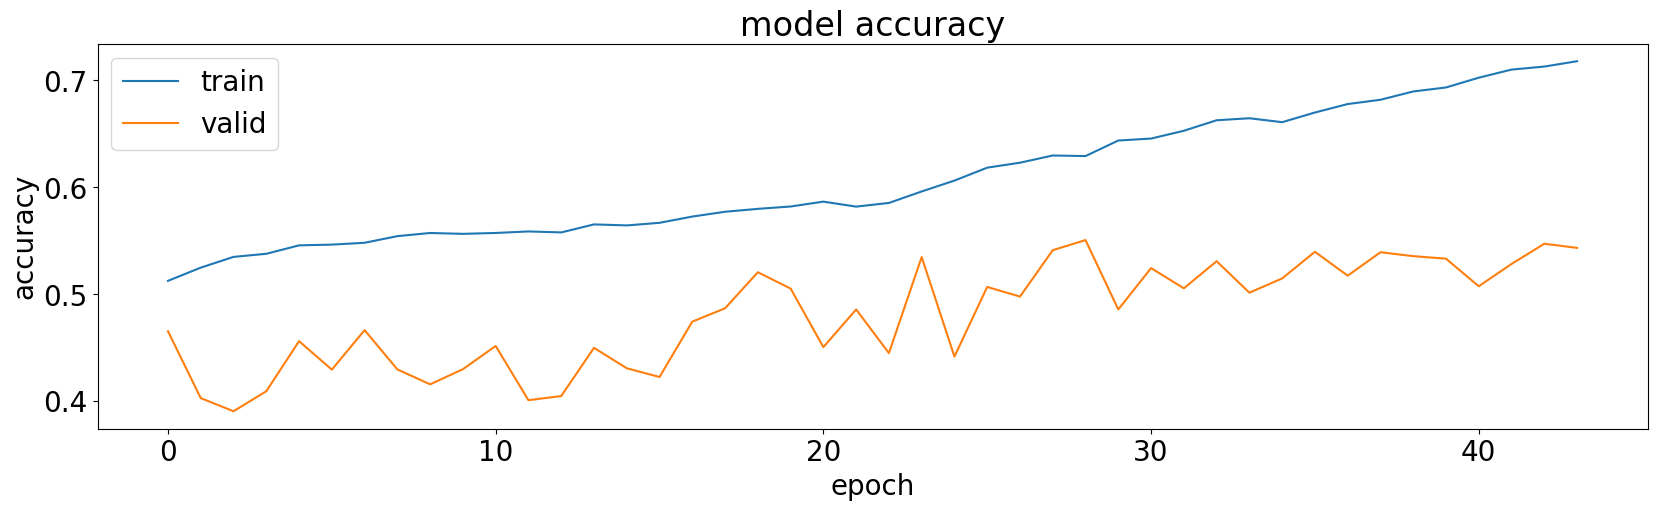

243/243 [==============================] - 7s 23ms/step


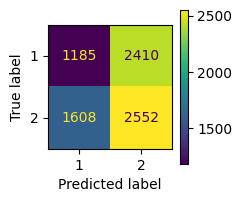

              precision    recall  f1-score   support

           1       0.42      0.33      0.37      3595
           2       0.51      0.61      0.56      4160

    accuracy                           0.48      7755
   macro avg       0.47      0.47      0.47      7755
weighted avg       0.47      0.48      0.47      7755

146/146 [==============================] - 6s 39ms/step
| 13        | 0.5505    | 8.71      | 2.721     | 0.3009    | 0.6171    | 1.98      | 6.054     | 4.43      | 4.786     |
1


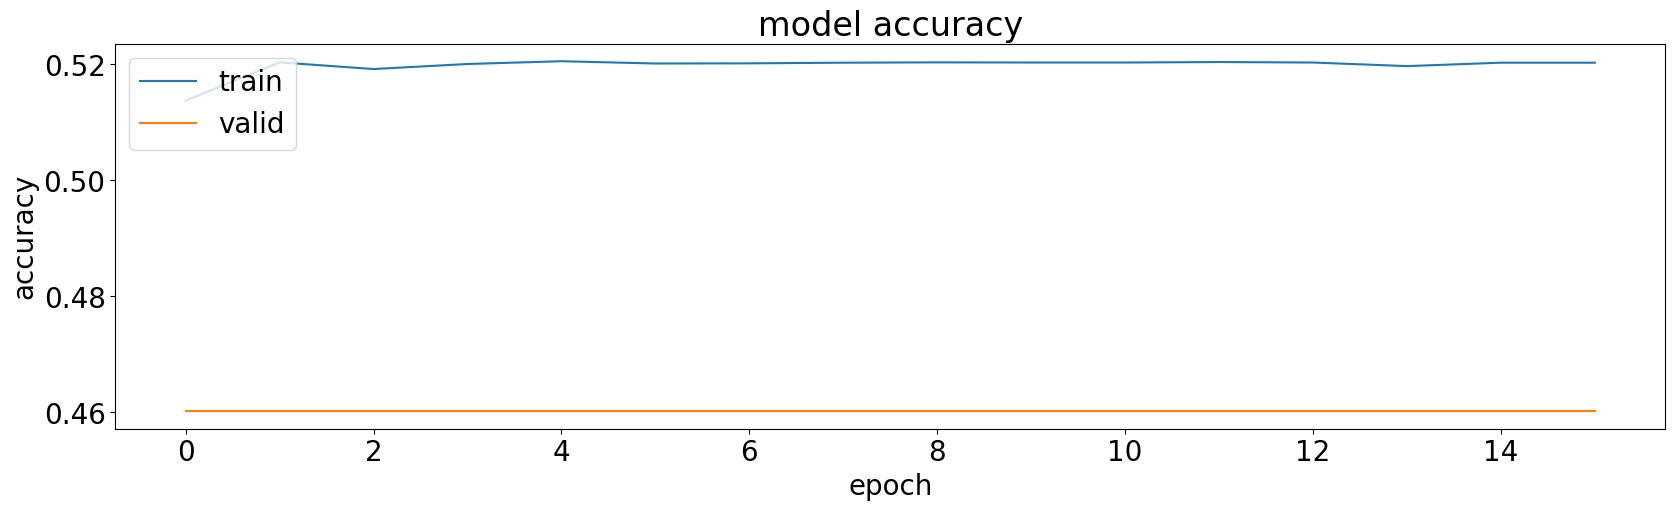

243/243 [==============================] - 12s 41ms/step


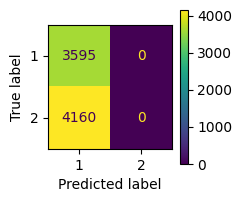

              precision    recall  f1-score   support

           1       0.46      1.00      0.63      3595
           2       0.00      0.00      0.00      4160

    accuracy                           0.46      7755
   macro avg       0.23      0.50      0.32      7755
weighted avg       0.21      0.46      0.29      7755

146/146 [==============================] - 4s 28ms/step
| 14        | 0.4602    | 8.726     | 2.87      | 0.3047    | 0.9294    | 3.073     | 6.995     | 0.8617    | 3.686     |
1


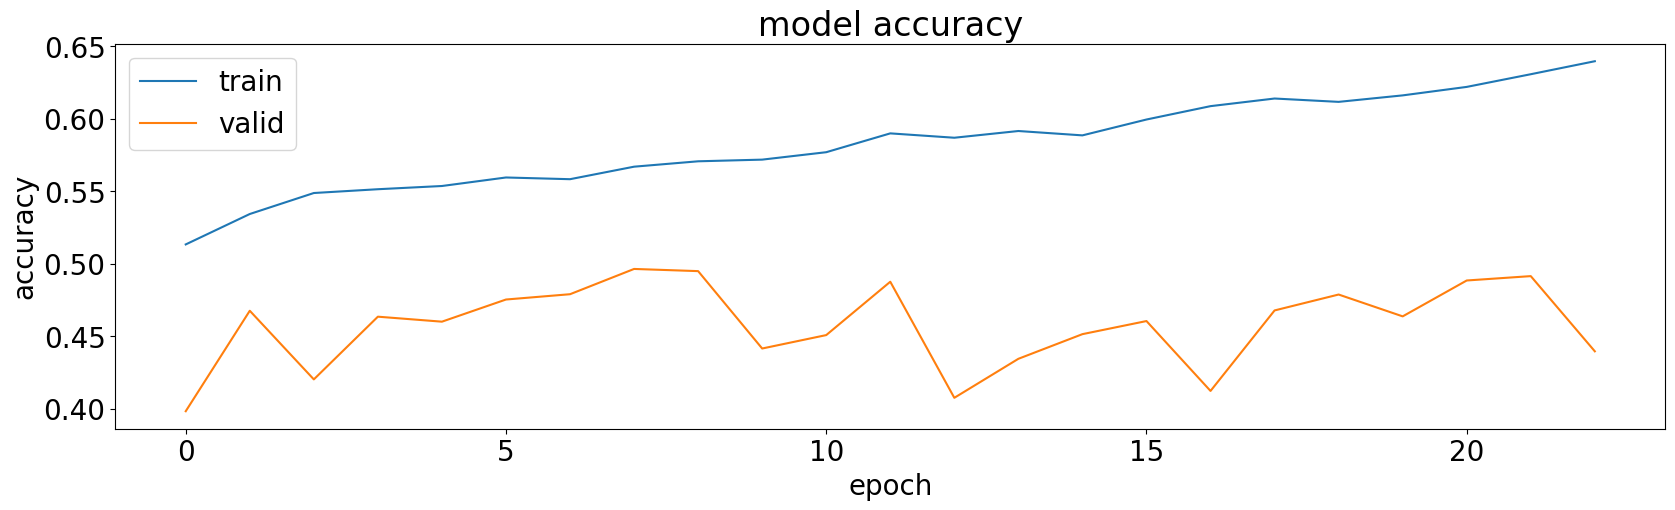

243/243 [==============================] - 11s 40ms/step


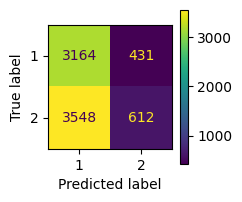

              precision    recall  f1-score   support

           1       0.47      0.88      0.61      3595
           2       0.59      0.15      0.24      4160

    accuracy                           0.49      7755
   macro avg       0.53      0.51      0.42      7755
weighted avg       0.53      0.49      0.41      7755

146/146 [==============================] - 8s 56ms/step
| 15        | 0.4963    | 8.798     | 3.09      | 0.3198    | 0.7555    | 3.262     | 6.846     | 3.558     | 3.621     |
1


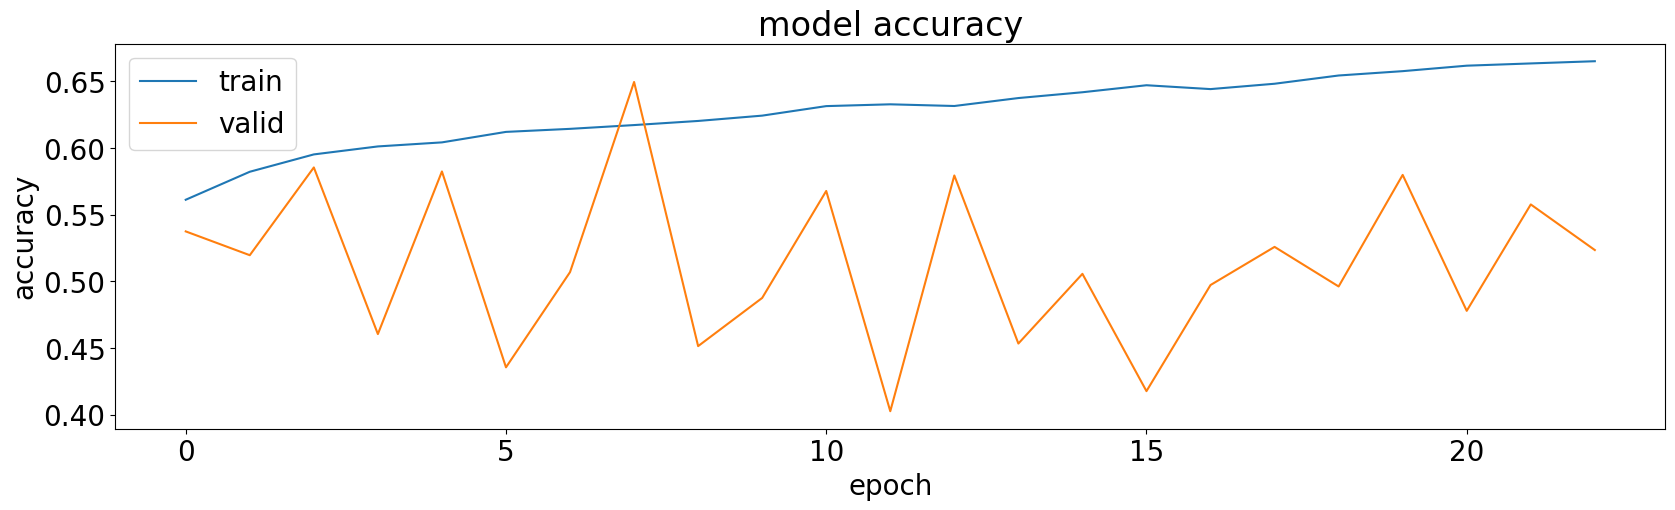

243/243 [==============================] - 3s 9ms/step


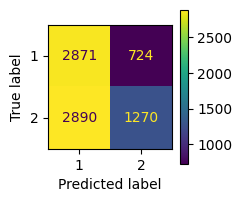

              precision    recall  f1-score   support

           1       0.50      0.80      0.61      3595
           2       0.64      0.31      0.41      4160

    accuracy                           0.53      7755
   macro avg       0.57      0.55      0.51      7755
weighted avg       0.57      0.53      0.51      7755

146/146 [==============================] - 1s 9ms/step
| 16        | 0.6495    | 7.053     | 1.276     | 0.3       | 1.0       | 1.0       | 6.46      | 2.546     | 4.556     |
0


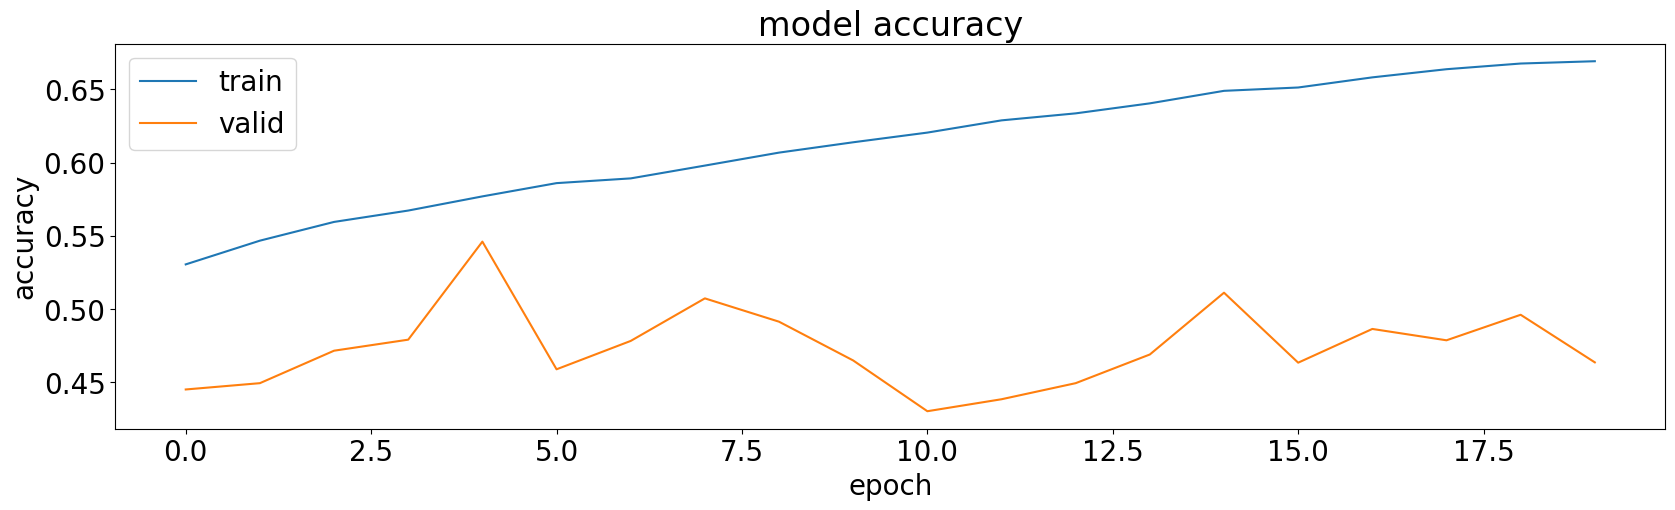

243/243 [==============================] - 3s 9ms/step


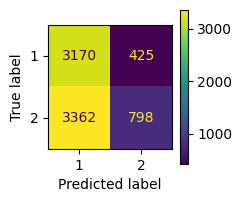

              precision    recall  f1-score   support

           1       0.49      0.88      0.63      3595
           2       0.65      0.19      0.30      4160

    accuracy                           0.51      7755
   macro avg       0.57      0.54      0.46      7755
weighted avg       0.57      0.51      0.45      7755

146/146 [==============================] - 2s 11ms/step
| 17        | 0.546     | 6.105     | 1.0       | 0.6       | 0.0       | 1.0       | 7.0       | 2.829     | 5.034     |
1


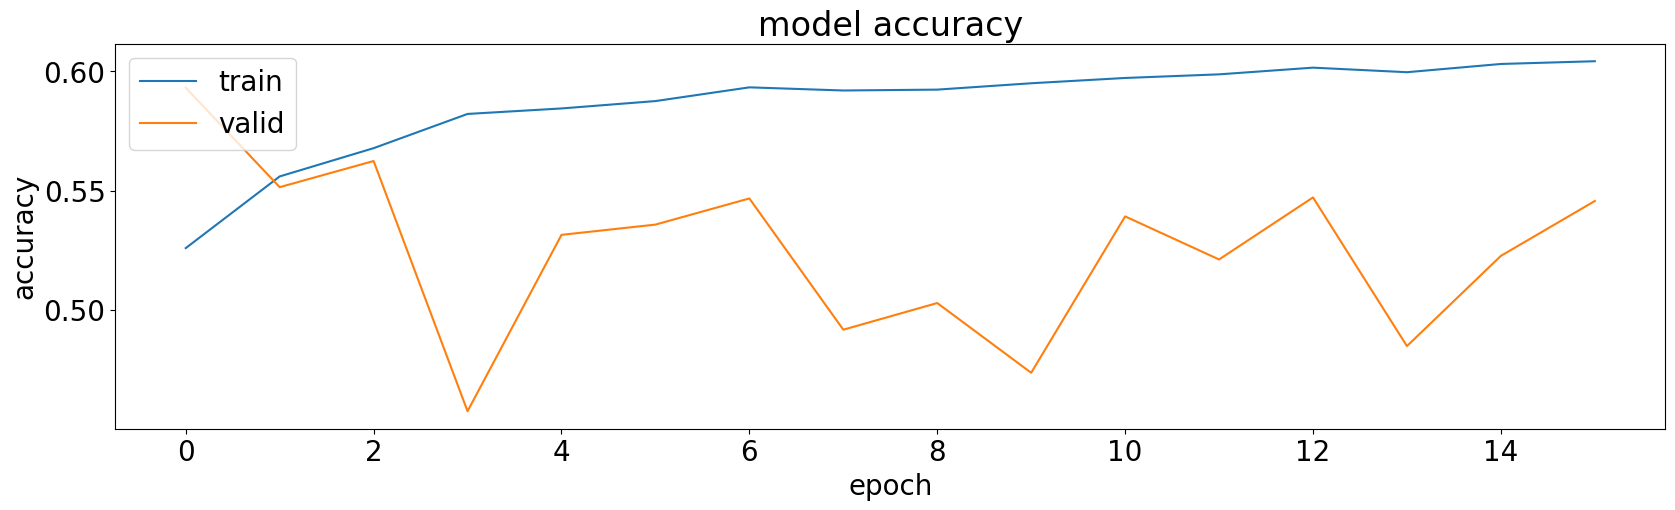

243/243 [==============================] - 3s 10ms/step


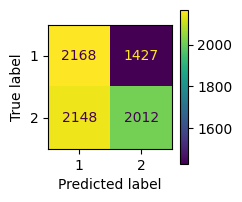

              precision    recall  f1-score   support

           1       0.50      0.60      0.55      3595
           2       0.59      0.48      0.53      4160

    accuracy                           0.54      7755
   macro avg       0.54      0.54      0.54      7755
weighted avg       0.55      0.54      0.54      7755

146/146 [==============================] - 2s 10ms/step
| 18        | 0.5931    | 8.154     | 1.0       | 0.3       | 1.0       | 1.0       | 5.835     | 2.357     | 4.251     |
1


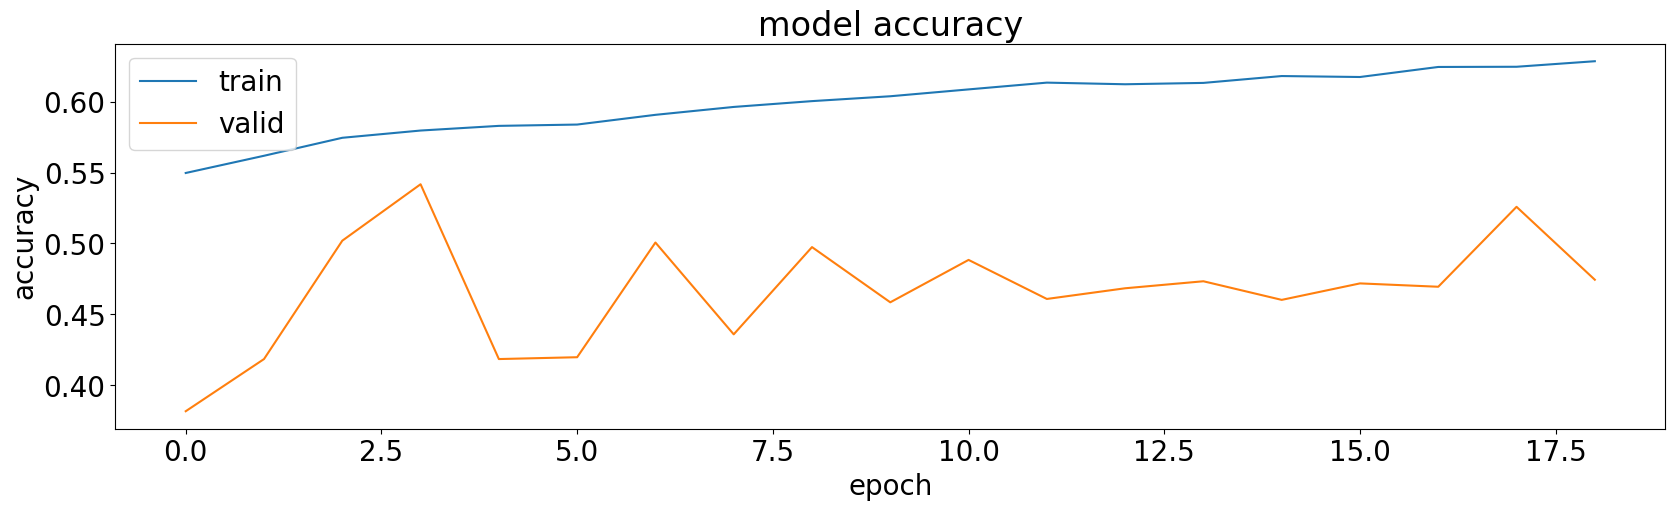

243/243 [==============================] - 3s 10ms/step


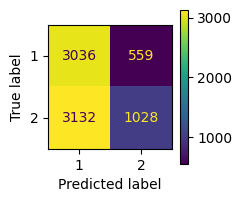

              precision    recall  f1-score   support

           1       0.49      0.84      0.62      3595
           2       0.65      0.25      0.36      4160

    accuracy                           0.52      7755
   macro avg       0.57      0.55      0.49      7755
weighted avg       0.58      0.52      0.48      7755

146/146 [==============================] - 2s 11ms/step
| 19        | 0.5417    | 6.926     | 2.219     | 0.3       | 1.0       | 1.0       | 5.98      | 3.029     | 4.294     |
1


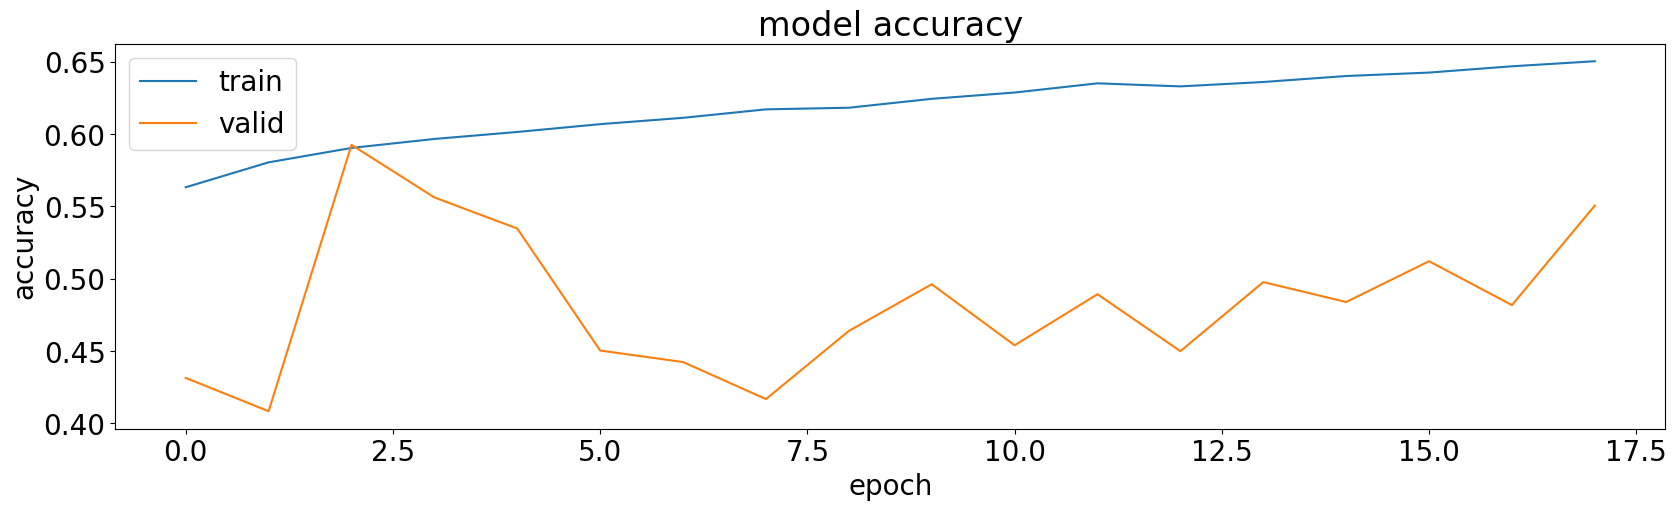

243/243 [==============================] - 6s 19ms/step


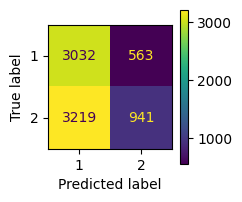

              precision    recall  f1-score   support

           1       0.49      0.84      0.62      3595
           2       0.63      0.23      0.33      4160

    accuracy                           0.51      7755
   macro avg       0.56      0.53      0.47      7755
weighted avg       0.56      0.51      0.46      7755

146/146 [==============================] - 3s 22ms/step
| 20        | 0.5925    | 7.259     | 1.0       | 0.3634    | 0.876     | 1.754     | 6.18      | 2.655     | 4.661     |
1


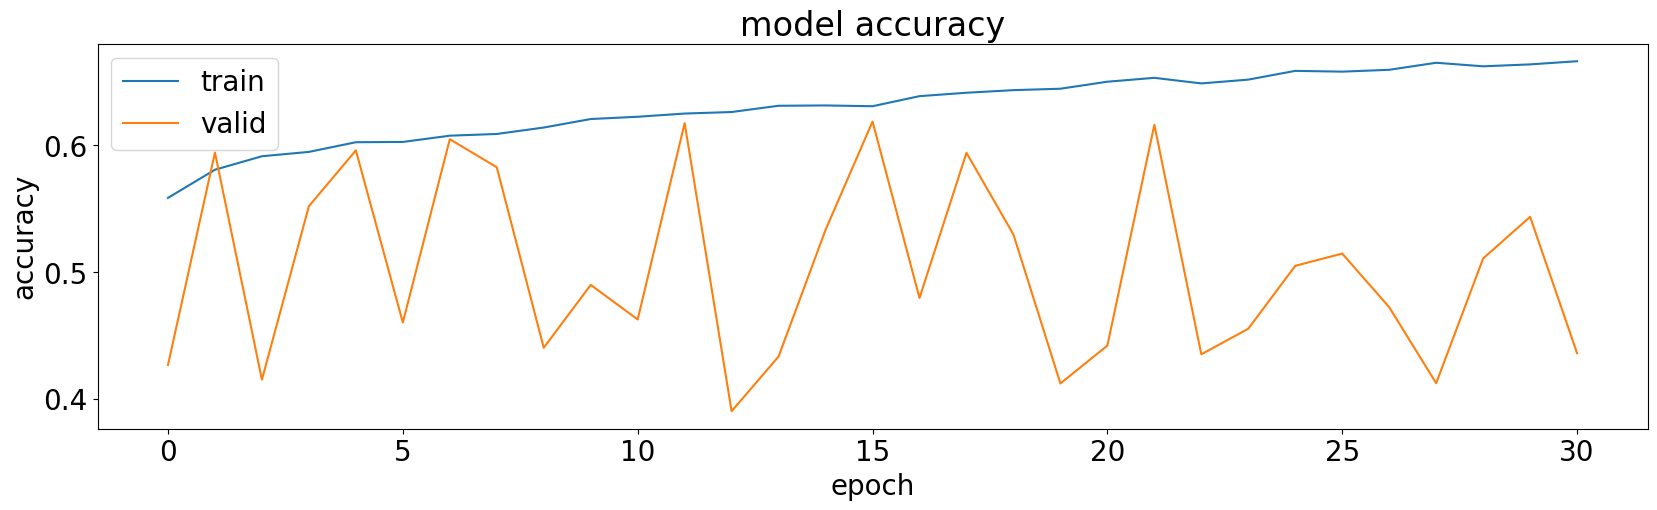

243/243 [==============================] - 4s 12ms/step


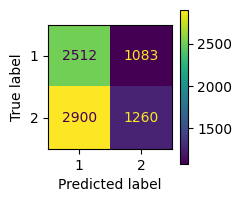

              precision    recall  f1-score   support

           1       0.46      0.70      0.56      3595
           2       0.54      0.30      0.39      4160

    accuracy                           0.49      7755
   macro avg       0.50      0.50      0.47      7755
weighted avg       0.50      0.49      0.47      7755

146/146 [==============================] - 2s 11ms/step
| 21        | 0.6189    | 7.662     | 1.237     | 0.3179    | 1.0       | 1.0       | 6.681     | 2.91      | 4.974     |
1


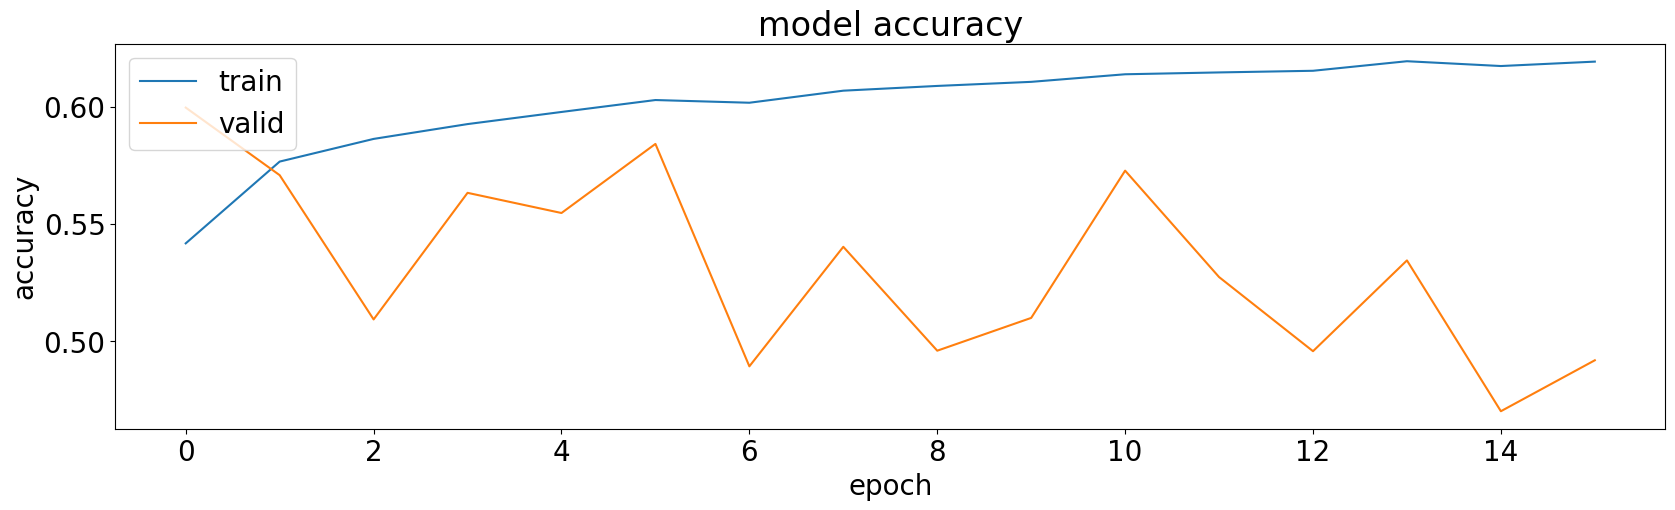

243/243 [==============================] - 3s 10ms/step


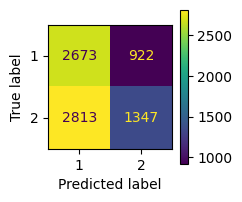

              precision    recall  f1-score   support

           1       0.49      0.74      0.59      3595
           2       0.59      0.32      0.42      4160

    accuracy                           0.52      7755
   macro avg       0.54      0.53      0.50      7755
weighted avg       0.54      0.52      0.50      7755

146/146 [==============================] - 1s 9ms/step
| 22        | 0.5996    | 7.103     | 1.0       | 0.3       | 1.0       | 1.0       | 6.742     | 2.248     | 3.801     |
1


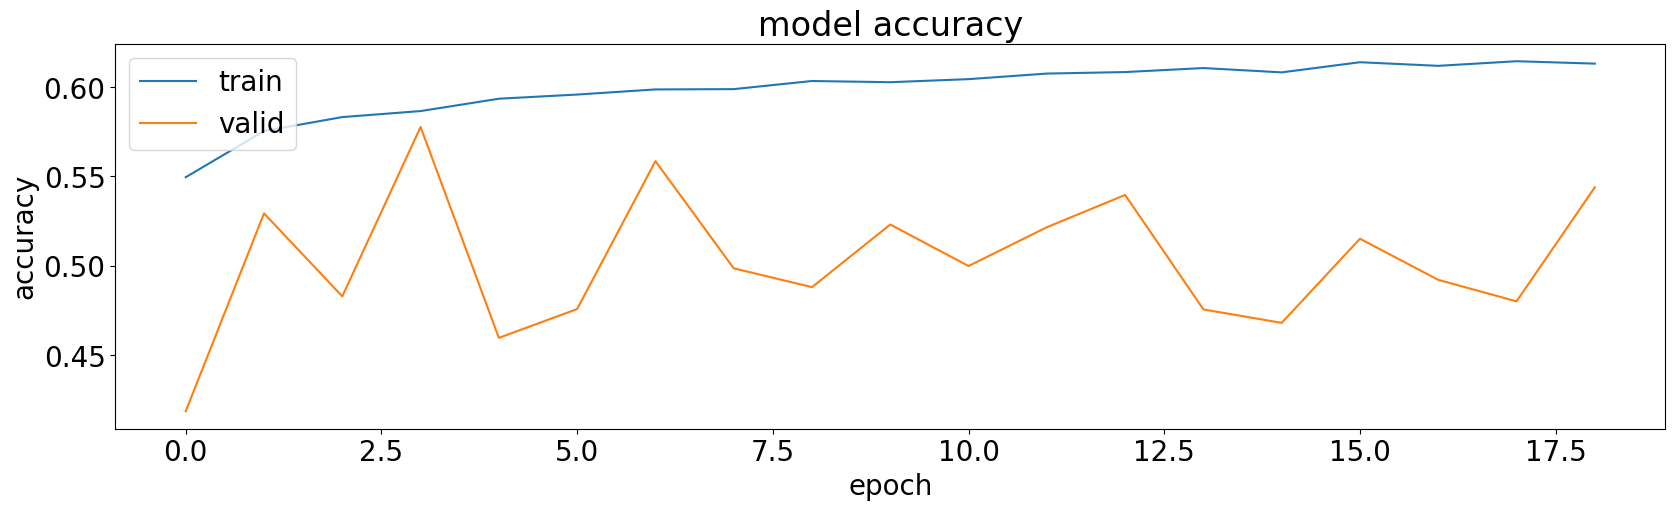

243/243 [==============================] - 3s 10ms/step


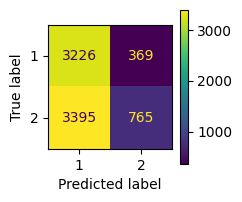

              precision    recall  f1-score   support

           1       0.49      0.90      0.63      3595
           2       0.67      0.18      0.29      4160

    accuracy                           0.51      7755
   macro avg       0.58      0.54      0.46      7755
weighted avg       0.59      0.51      0.45      7755

146/146 [==============================] - 1s 10ms/step
| 23        | 0.5776    | 7.144     | 1.283     | 0.3       | 1.0       | 1.0       | 6.318     | 1.869     | 5.04      |
1


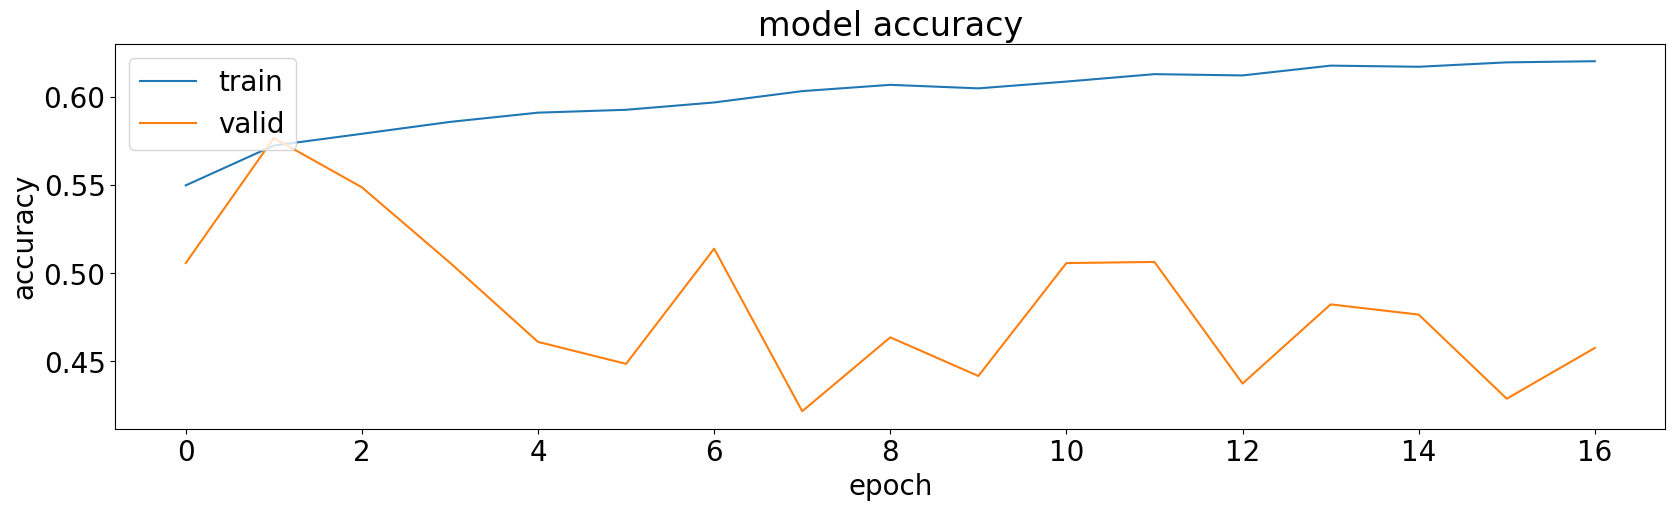

243/243 [==============================] - 3s 11ms/step


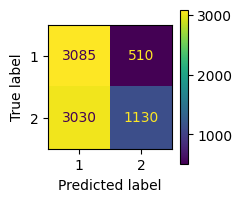

              precision    recall  f1-score   support

           1       0.50      0.86      0.64      3595
           2       0.69      0.27      0.39      4160

    accuracy                           0.54      7755
   macro avg       0.60      0.56      0.51      7755
weighted avg       0.60      0.54      0.50      7755

146/146 [==============================] - 1s 10ms/step
| 24        | 0.5766    | 7.226     | 1.0       | 0.6       | 1.0       | 1.0       | 6.195     | 3.206     | 4.354     |
0


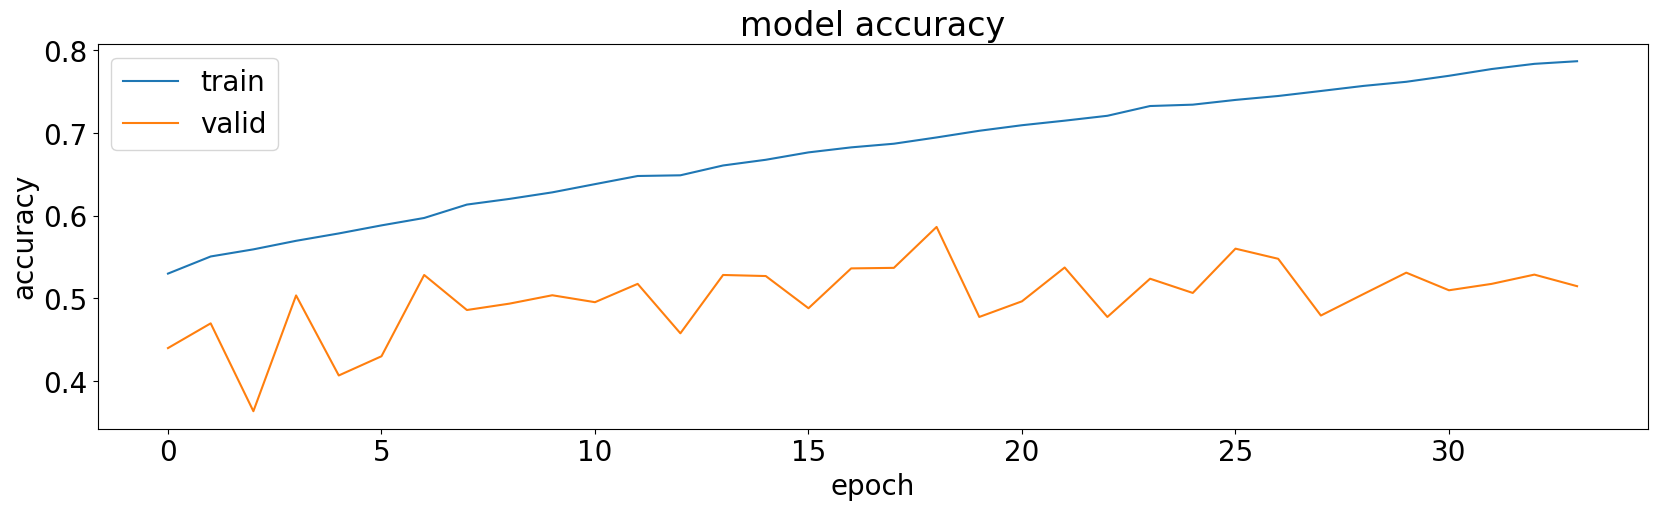

243/243 [==============================] - 3s 10ms/step


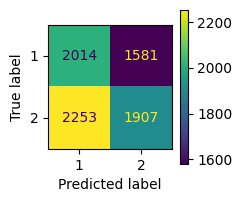

              precision    recall  f1-score   support

           1       0.47      0.56      0.51      3595
           2       0.55      0.46      0.50      4160

    accuracy                           0.51      7755
   macro avg       0.51      0.51      0.51      7755
weighted avg       0.51      0.51      0.51      7755

146/146 [==============================] - 1s 10ms/step
| 25        | 0.5865    | 7.448     | 1.429     | 0.3       | 0.3765    | 1.0       | 6.514     | 2.535     | 4.472     |
1


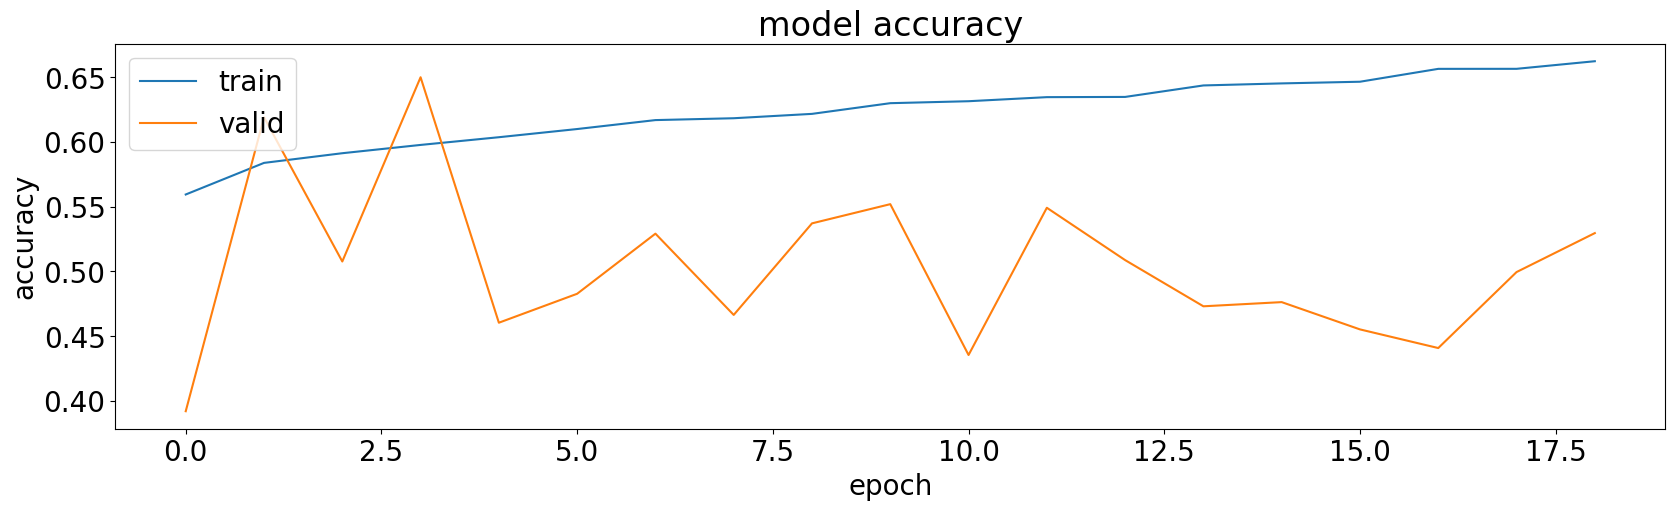

243/243 [==============================] - 3s 10ms/step


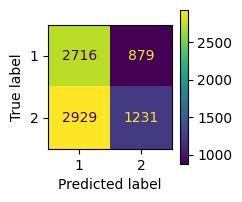

              precision    recall  f1-score   support

           1       0.48      0.76      0.59      3595
           2       0.58      0.30      0.39      4160

    accuracy                           0.51      7755
   macro avg       0.53      0.53      0.49      7755
weighted avg       0.54      0.51      0.48      7755

146/146 [==============================] - 1s 10ms/step
| 26        | 0.6499    | 7.133     | 1.28      | 0.3       | 1.0       | 1.0       | 6.07      | 3.017     | 5.402     |
1


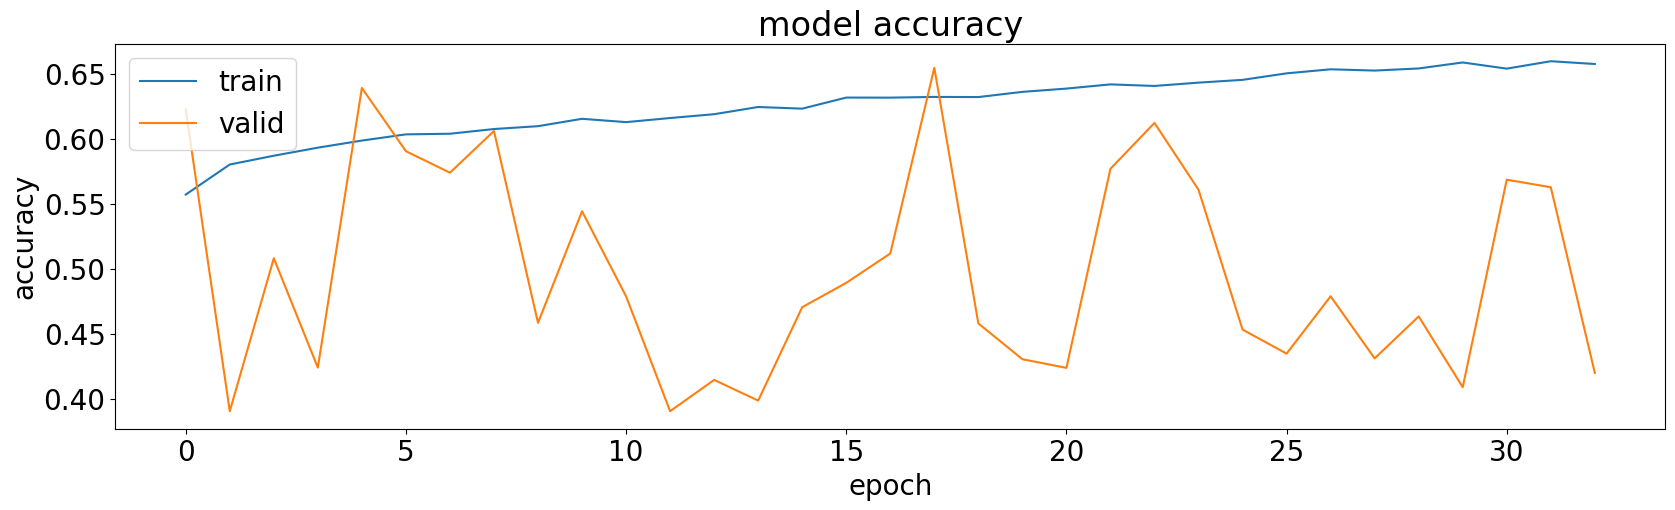

243/243 [==============================] - 3s 10ms/step


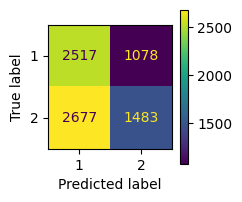

              precision    recall  f1-score   support

           1       0.48      0.70      0.57      3595
           2       0.58      0.36      0.44      4160

    accuracy                           0.52      7755
   macro avg       0.53      0.53      0.51      7755
weighted avg       0.54      0.52      0.50      7755

146/146 [==============================] - 1s 9ms/step
| 27        | 0.6544    | 7.774     | 1.074     | 0.3       | 1.0       | 1.0       | 5.764     | 3.275     | 5.875     |
1


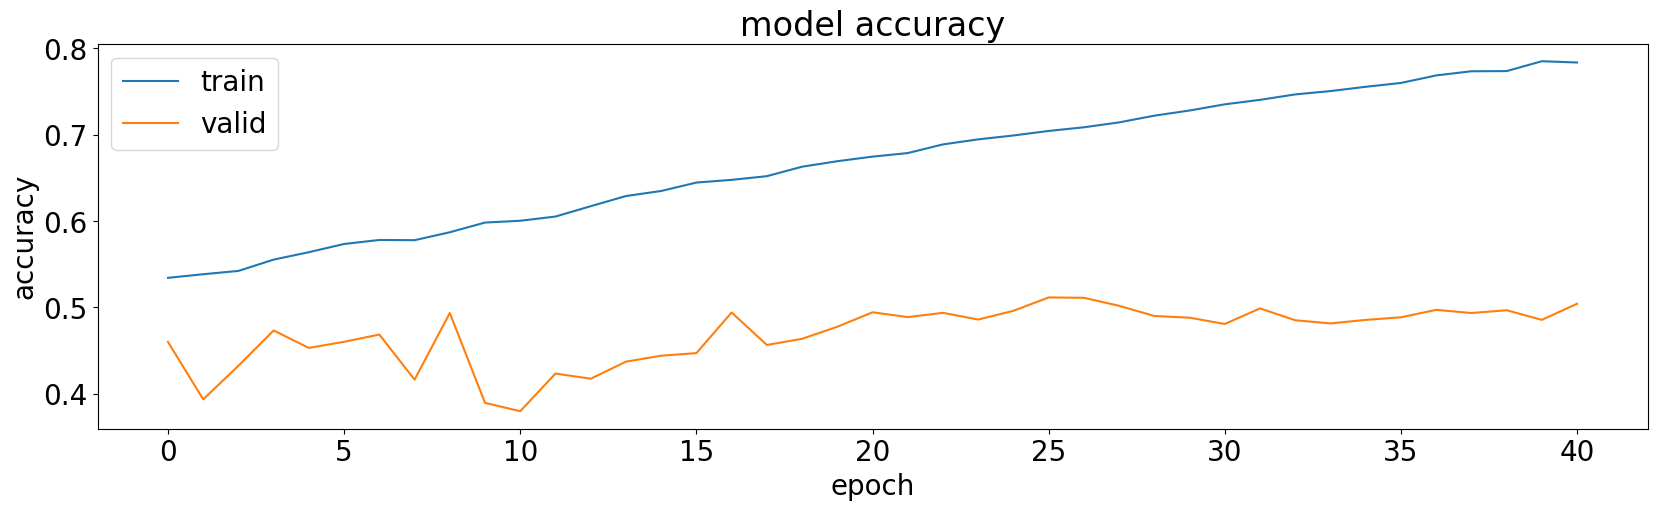

243/243 [==============================] - 3s 10ms/step


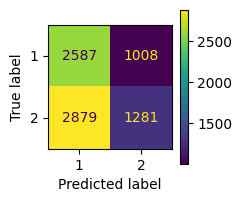

              precision    recall  f1-score   support

           1       0.47      0.72      0.57      3595
           2       0.56      0.31      0.40      4160

    accuracy                           0.50      7755
   macro avg       0.52      0.51      0.48      7755
weighted avg       0.52      0.50      0.48      7755

146/146 [==============================] - 2s 11ms/step
| 28        | 0.5114    | 7.326     | 1.375     | 0.3       | 1.0       | 1.042     | 6.209     | 3.869     | 6.069     |
1


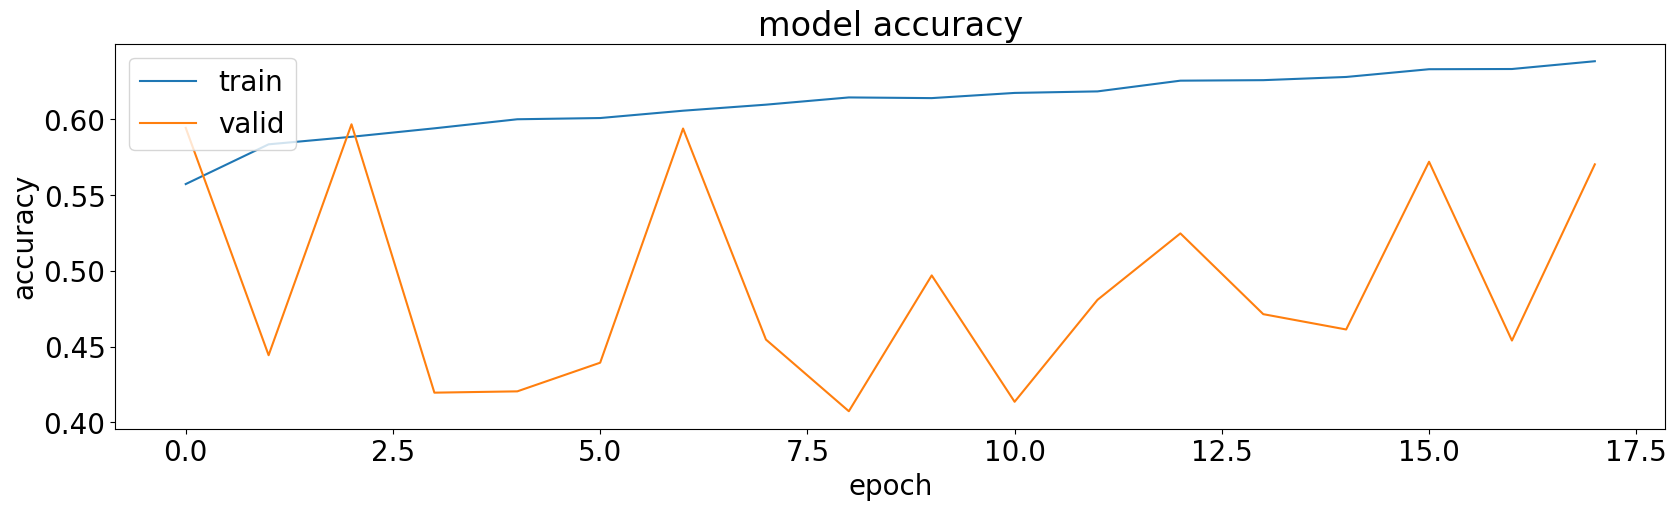

243/243 [==============================] - 3s 10ms/step


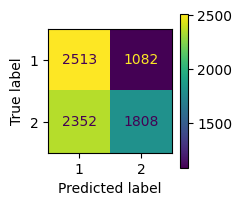

              precision    recall  f1-score   support

           1       0.52      0.70      0.59      3595
           2       0.63      0.43      0.51      4160

    accuracy                           0.56      7755
   macro avg       0.57      0.57      0.55      7755
weighted avg       0.58      0.56      0.55      7755

146/146 [==============================] - 1s 10ms/step
| 29        | 0.5968    | 7.727     | 1.078     | 0.3       | 1.0       | 1.0       | 5.585     | 2.822     | 5.374     |
1


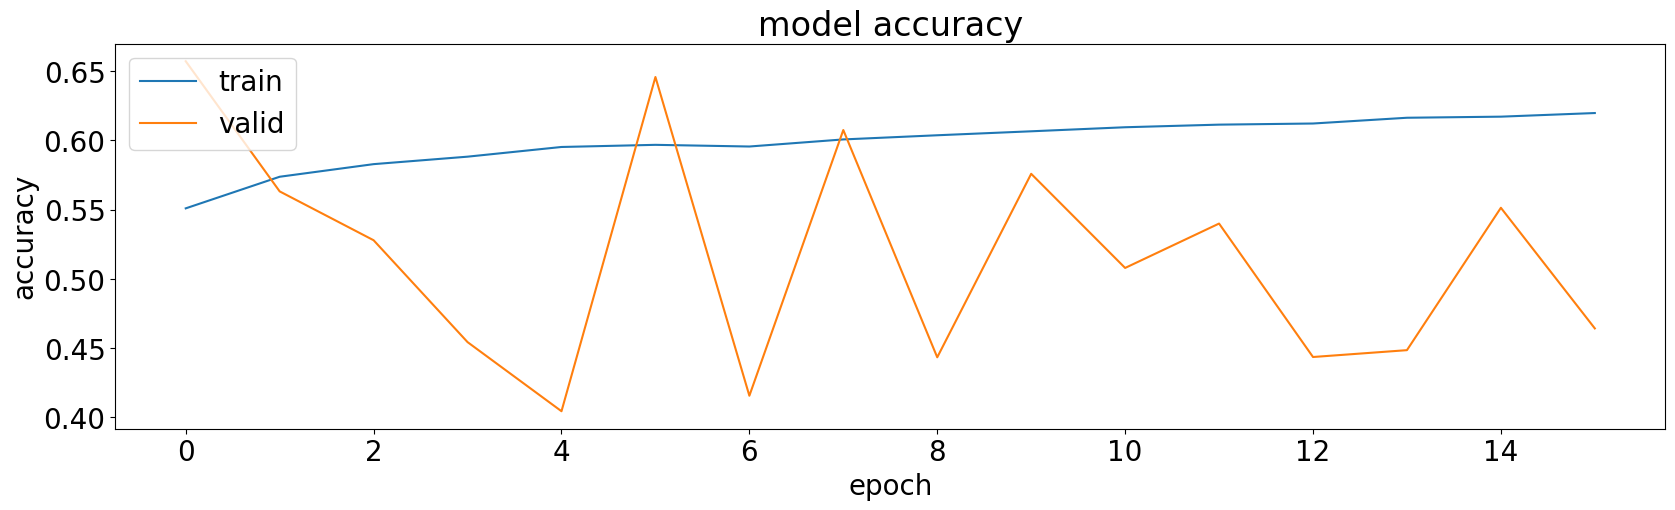

243/243 [==============================] - 3s 11ms/step


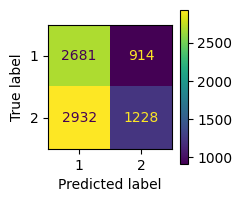

              precision    recall  f1-score   support

           1       0.48      0.75      0.58      3595
           2       0.57      0.30      0.39      4160

    accuracy                           0.50      7755
   macro avg       0.53      0.52      0.49      7755
weighted avg       0.53      0.50      0.48      7755

146/146 [==============================] - 2s 12ms/step
| 30        | 0.6572    | 7.626     | 1.0       | 0.4571    | 0.6625    | 1.168     | 6.156     | 3.055     | 5.638     |
1


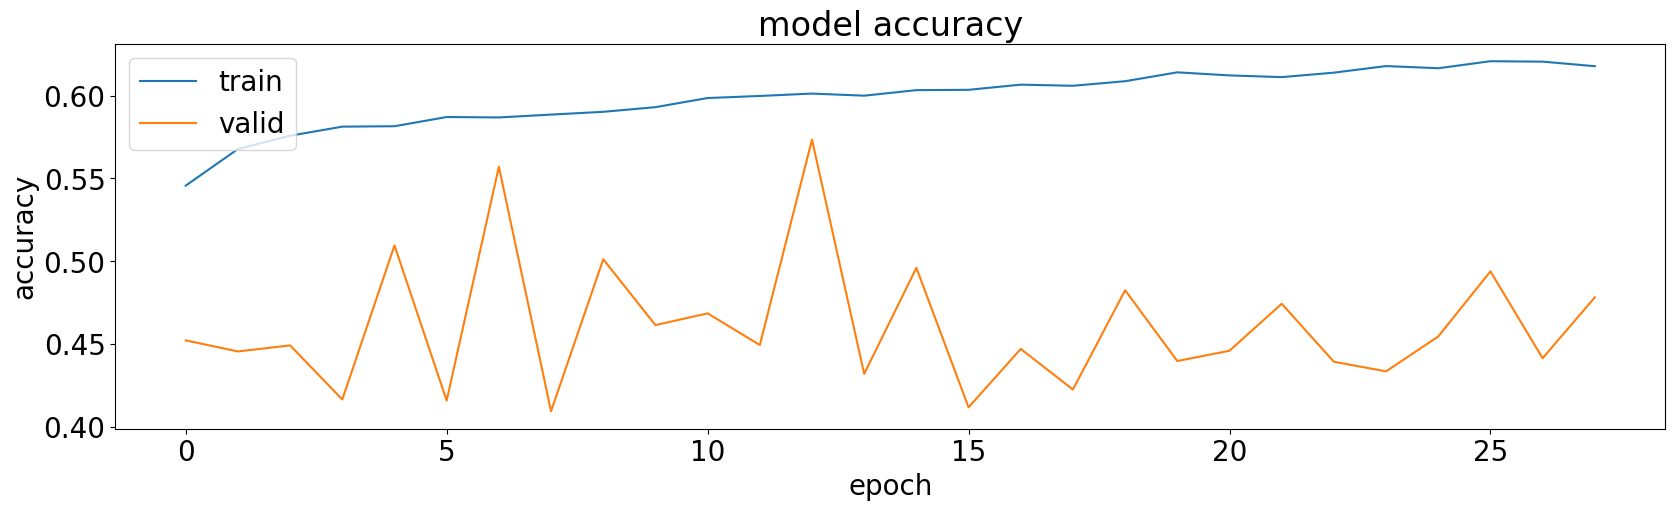

243/243 [==============================] - 3s 10ms/step


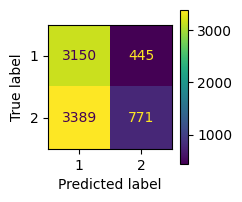

              precision    recall  f1-score   support

           1       0.48      0.88      0.62      3595
           2       0.63      0.19      0.29      4160

    accuracy                           0.51      7755
   macro avg       0.56      0.53      0.45      7755
weighted avg       0.56      0.51      0.44      7755

146/146 [==============================] - 2s 11ms/step
| 31        | 0.5733    | 7.781     | 1.461     | 0.6       | 1.0       | 1.292     | 6.088     | 2.932     | 5.765     |
0


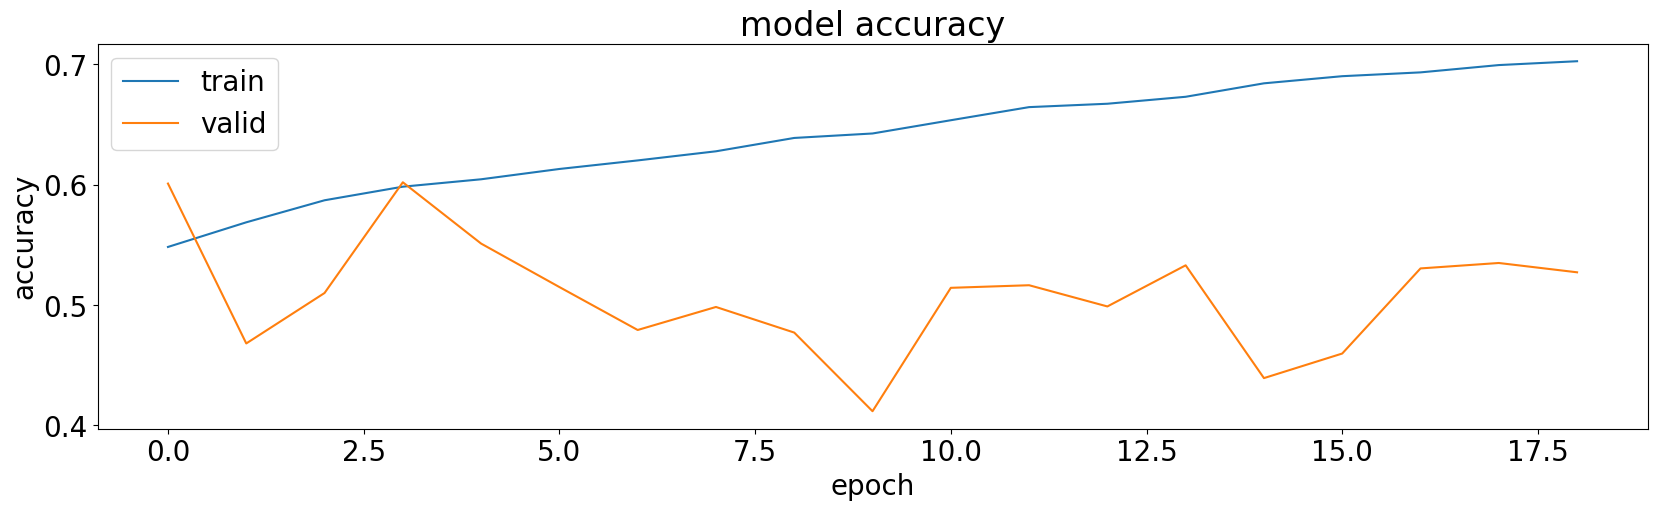

243/243 [==============================] - 3s 10ms/step


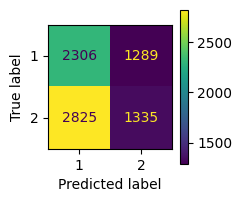

              precision    recall  f1-score   support

           1       0.45      0.64      0.53      3595
           2       0.51      0.32      0.39      4160

    accuracy                           0.47      7755
   macro avg       0.48      0.48      0.46      7755
weighted avg       0.48      0.47      0.46      7755

146/146 [==============================] - 1s 9ms/step
| 32        | 0.6019    | 7.412     | 1.0       | 0.3       | 0.4862    | 1.0       | 5.765     | 3.296     | 5.534     |
1


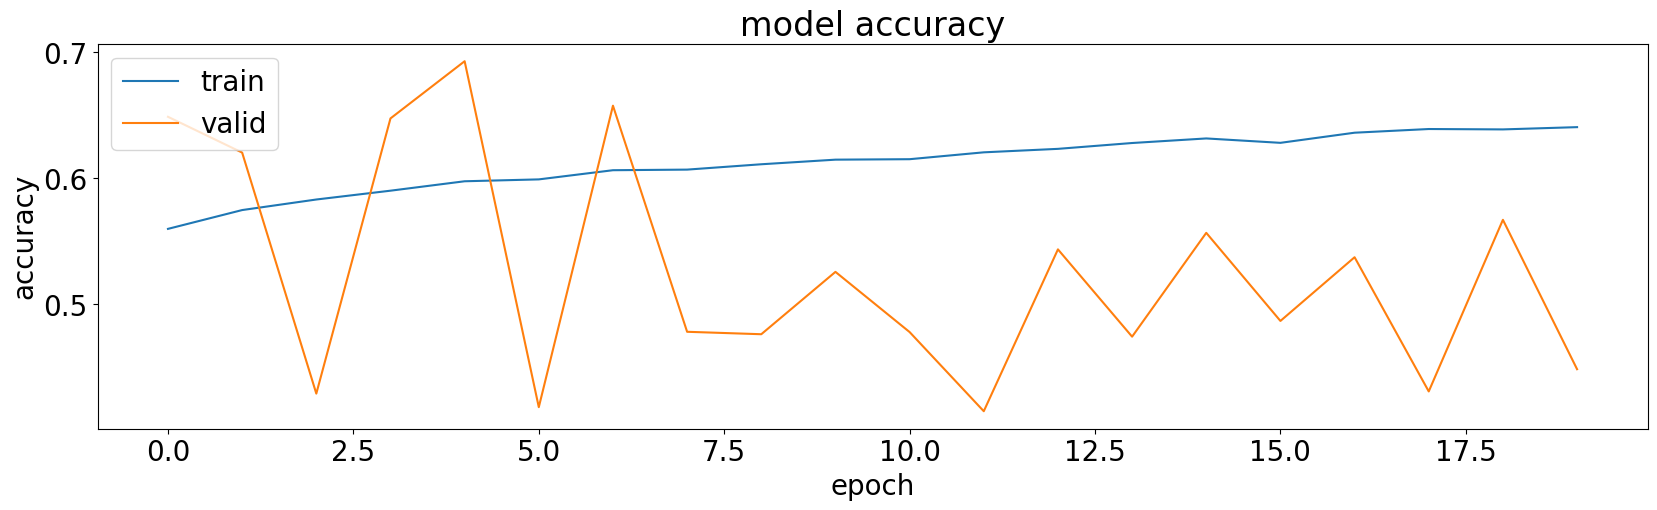

243/243 [==============================] - 3s 11ms/step


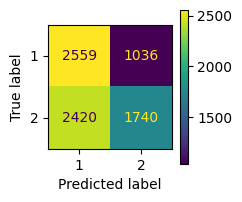

              precision    recall  f1-score   support

           1       0.51      0.71      0.60      3595
           2       0.63      0.42      0.50      4160

    accuracy                           0.55      7755
   macro avg       0.57      0.57      0.55      7755
weighted avg       0.57      0.55      0.55      7755

146/146 [==============================] - 2s 11ms/step
| 33        | 0.6929    | 7.73      | 1.0       | 0.3       | 1.0       | 1.0       | 6.165     | 3.292     | 5.391     |
1


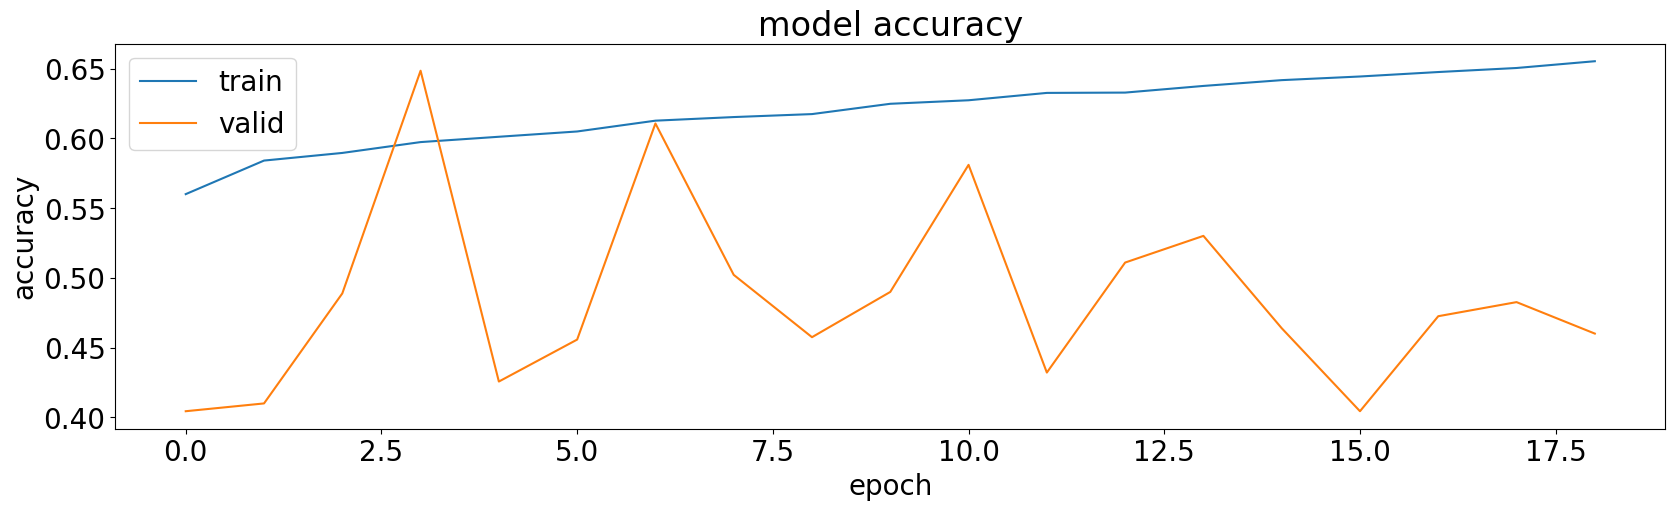

243/243 [==============================] - 3s 11ms/step


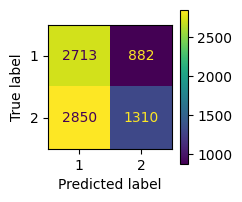

              precision    recall  f1-score   support

           1       0.49      0.75      0.59      3595
           2       0.60      0.31      0.41      4160

    accuracy                           0.52      7755
   macro avg       0.54      0.53      0.50      7755
weighted avg       0.55      0.52      0.50      7755

146/146 [==============================] - 2s 12ms/step
| 34        | 0.6486    | 7.446     | 1.0       | 0.3       | 1.0       | 1.0       | 6.459     | 3.073     | 5.559     |
1


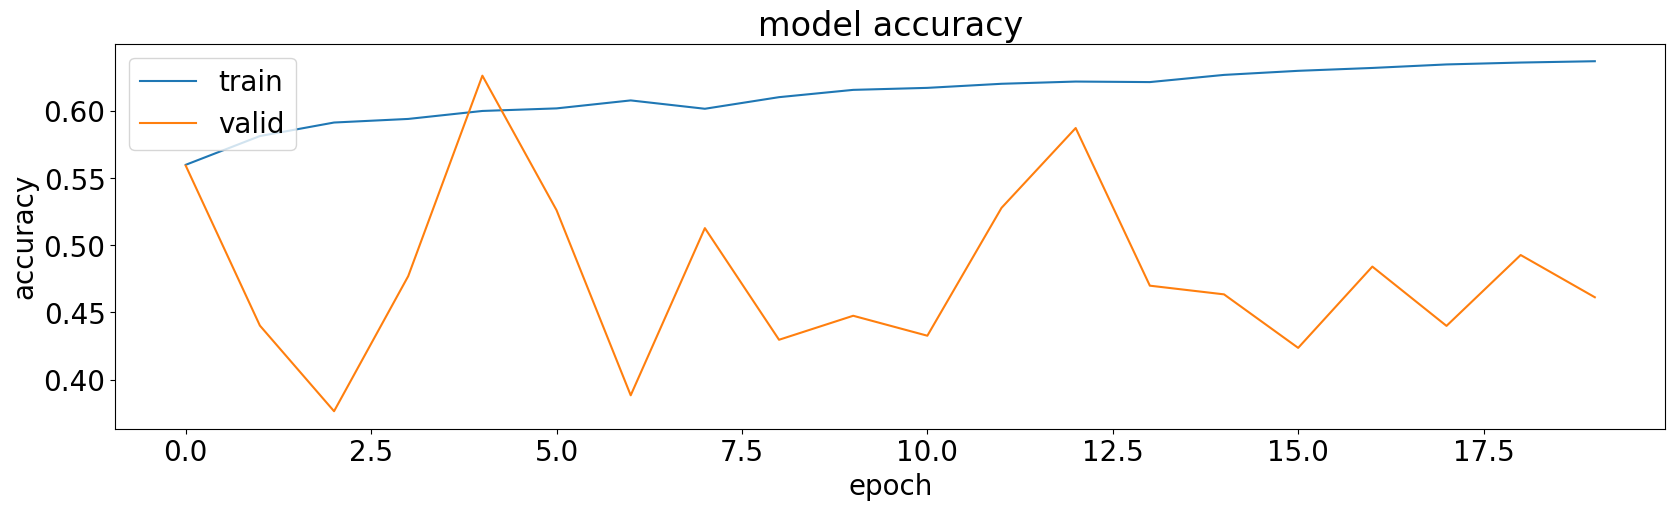

243/243 [==============================] - 4s 14ms/step


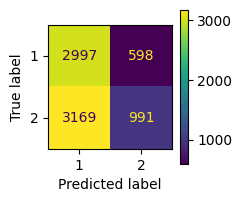

              precision    recall  f1-score   support

           1       0.49      0.83      0.61      3595
           2       0.62      0.24      0.34      4160

    accuracy                           0.51      7755
   macro avg       0.55      0.54      0.48      7755
weighted avg       0.56      0.51      0.47      7755

146/146 [==============================] - 2s 11ms/step
| 35        | 0.626     | 8.24      | 1.0       | 0.3       | 0.8035    | 1.0       | 6.141     | 3.396     | 5.492     |
1


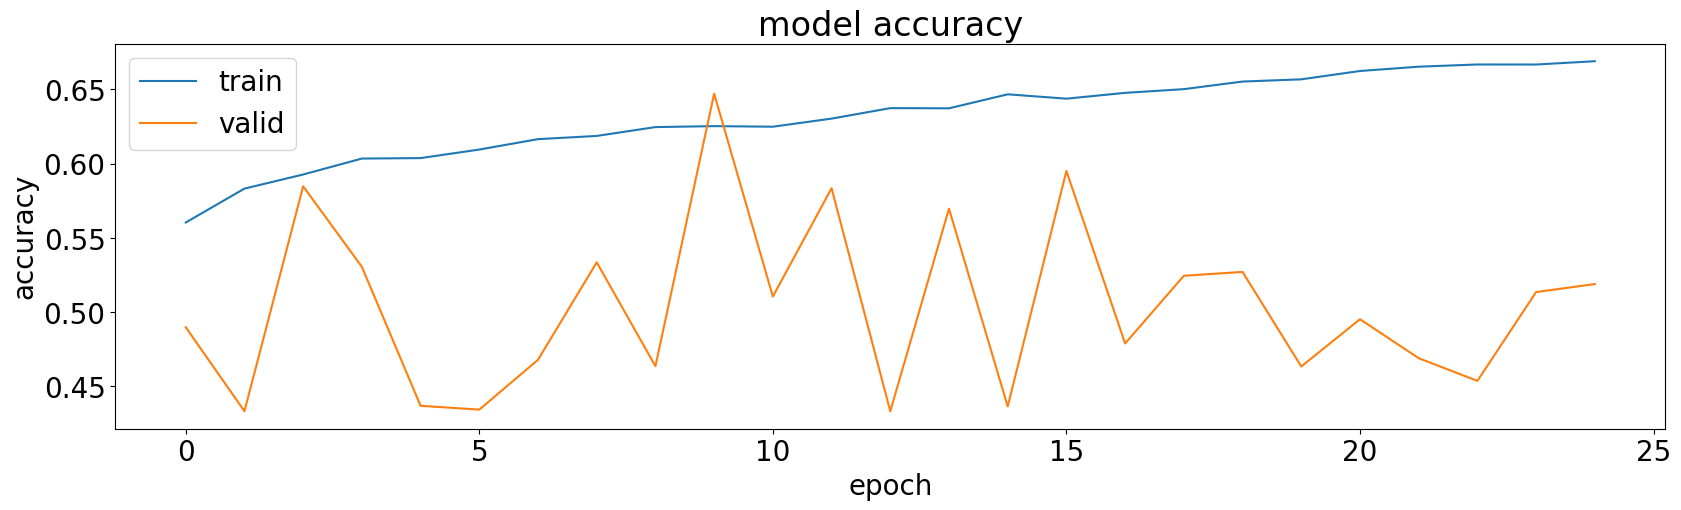

243/243 [==============================] - 3s 11ms/step


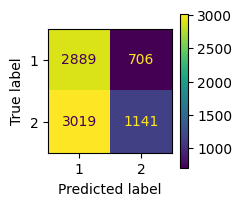

              precision    recall  f1-score   support

           1       0.49      0.80      0.61      3595
           2       0.62      0.27      0.38      4160

    accuracy                           0.52      7755
   macro avg       0.55      0.54      0.49      7755
weighted avg       0.56      0.52      0.49      7755

146/146 [==============================] - 2s 12ms/step
| 36        | 0.6471    | 6.762     | 1.0       | 0.3       | 1.0       | 1.0       | 6.463     | 2.812     | 5.037     |
1


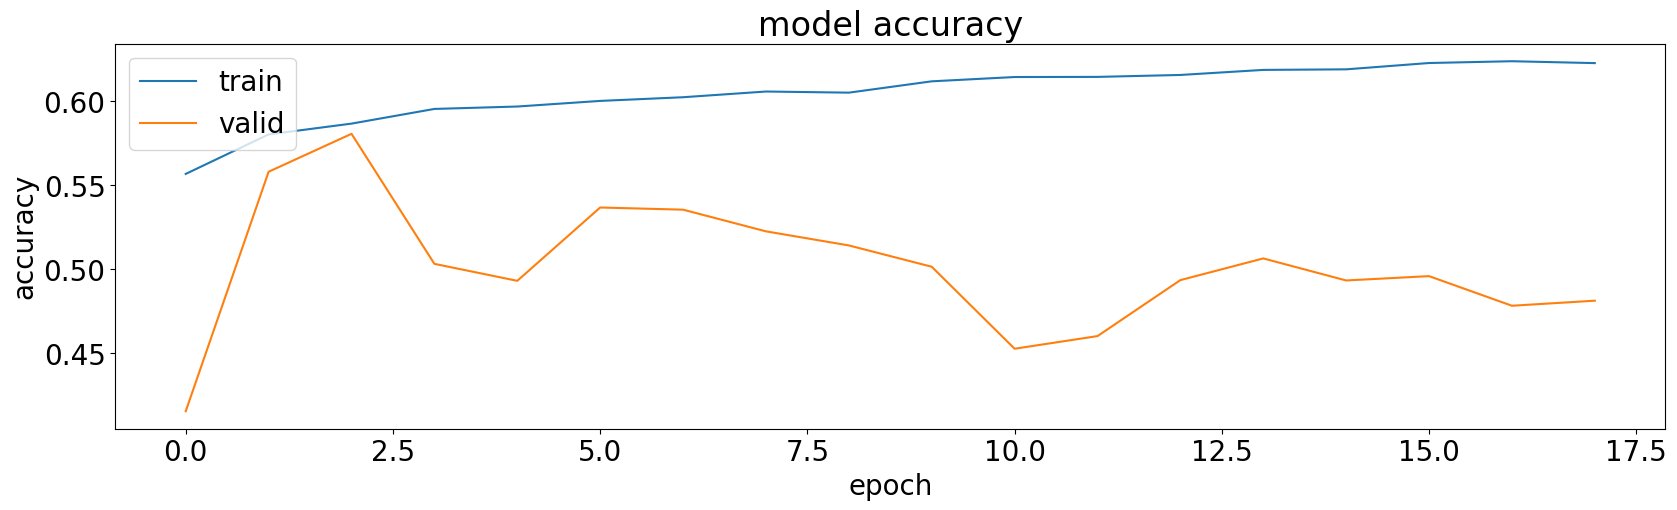

243/243 [==============================] - 3s 11ms/step


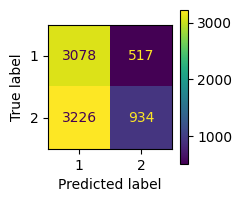

              precision    recall  f1-score   support

           1       0.49      0.86      0.62      3595
           2       0.64      0.22      0.33      4160

    accuracy                           0.52      7755
   macro avg       0.57      0.54      0.48      7755
weighted avg       0.57      0.52      0.47      7755

146/146 [==============================] - 1s 9ms/step
| 37        | 0.5806    | 6.349     | 1.026     | 0.3       | 1.0       | 1.0       | 6.19      | 2.394     | 4.448     |
1


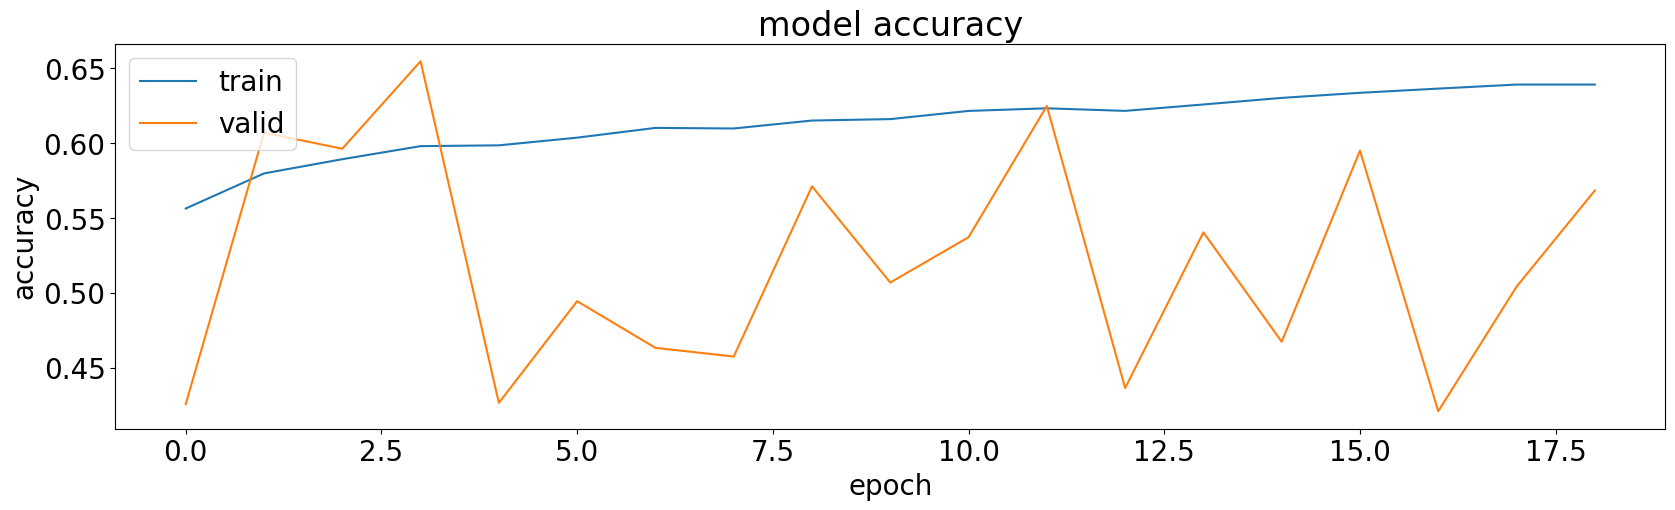

243/243 [==============================] - 3s 12ms/step


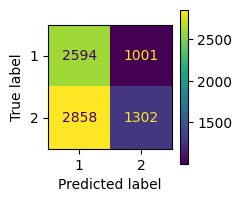

              precision    recall  f1-score   support

           1       0.48      0.72      0.57      3595
           2       0.57      0.31      0.40      4160

    accuracy                           0.50      7755
   macro avg       0.52      0.52      0.49      7755
weighted avg       0.52      0.50      0.48      7755

146/146 [==============================] - 2s 11ms/step
| 38        | 0.6548    | 7.601     | 1.0       | 0.3       | 1.0       | 1.459     | 6.119     | 3.35      | 5.326     |
1


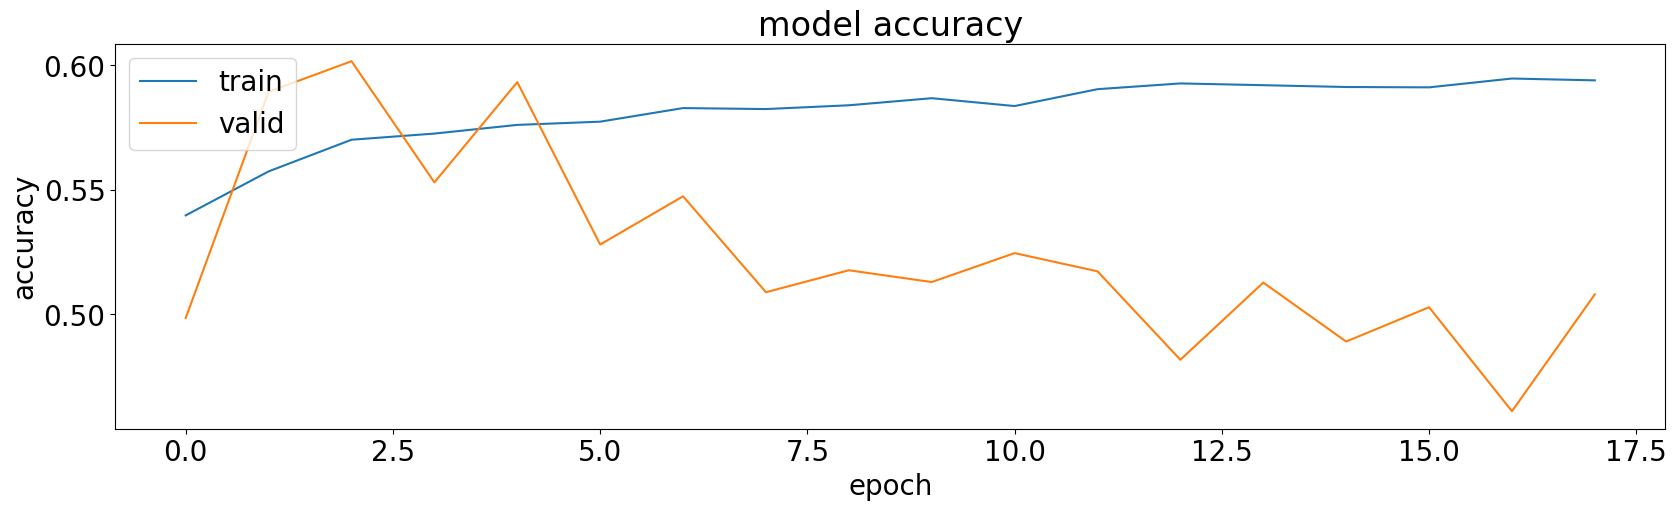

243/243 [==============================] - 3s 9ms/step


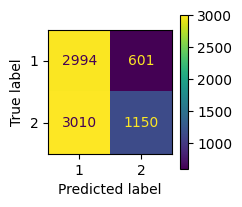

              precision    recall  f1-score   support

           1       0.50      0.83      0.62      3595
           2       0.66      0.28      0.39      4160

    accuracy                           0.53      7755
   macro avg       0.58      0.55      0.51      7755
weighted avg       0.58      0.53      0.50      7755

146/146 [==============================] - 1s 9ms/step
| 39        | 0.6015    | 7.579     | 1.0       | 0.3       | 1.0       | 1.418     | 5.425     | 1.747     | 3.0       |
0


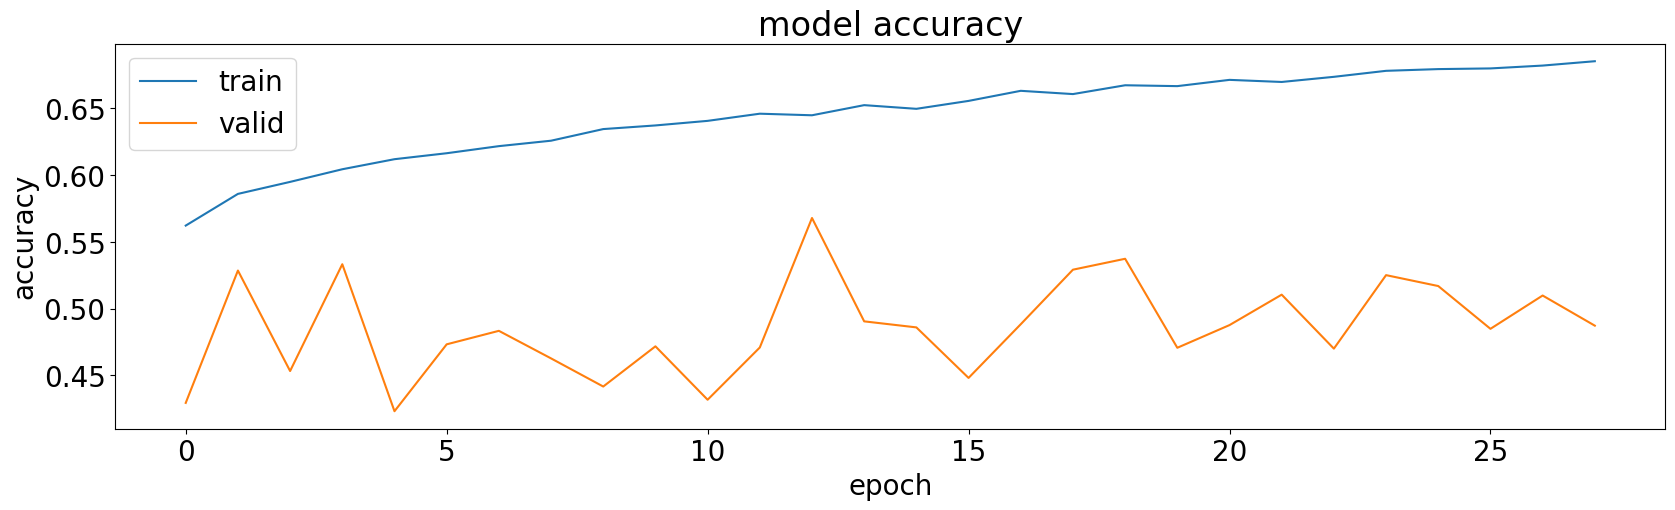

243/243 [==============================] - 6s 21ms/step


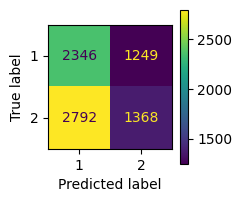

              precision    recall  f1-score   support

           1       0.46      0.65      0.54      3595
           2       0.52      0.33      0.40      4160

    accuracy                           0.48      7755
   macro avg       0.49      0.49      0.47      7755
weighted avg       0.49      0.48      0.47      7755

146/146 [==============================] - 3s 20ms/step
| 40        | 0.568     | 6.95      | 1.0       | 0.3       | 0.3213    | 2.283     | 5.0       | 1.885     | 3.0       |
1


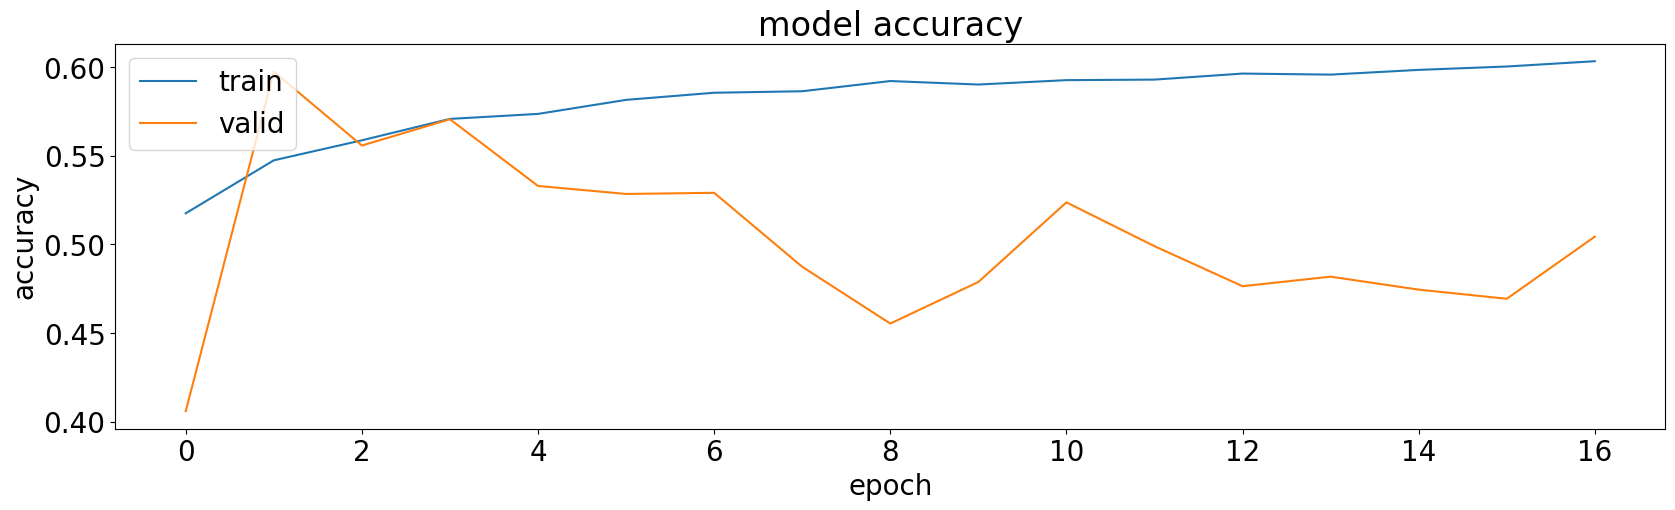

243/243 [==============================] - 4s 11ms/step


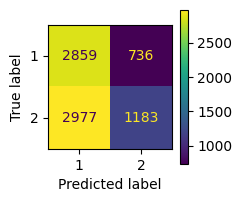

              precision    recall  f1-score   support

           1       0.49      0.80      0.61      3595
           2       0.62      0.28      0.39      4160

    accuracy                           0.52      7755
   macro avg       0.55      0.54      0.50      7755
weighted avg       0.56      0.52      0.49      7755

146/146 [==============================] - 1s 10ms/step
| 41        | 0.5974    | 6.76      | 1.683     | 0.3       | 1.0       | 1.269     | 6.062     | 1.602     | 3.0       |
0


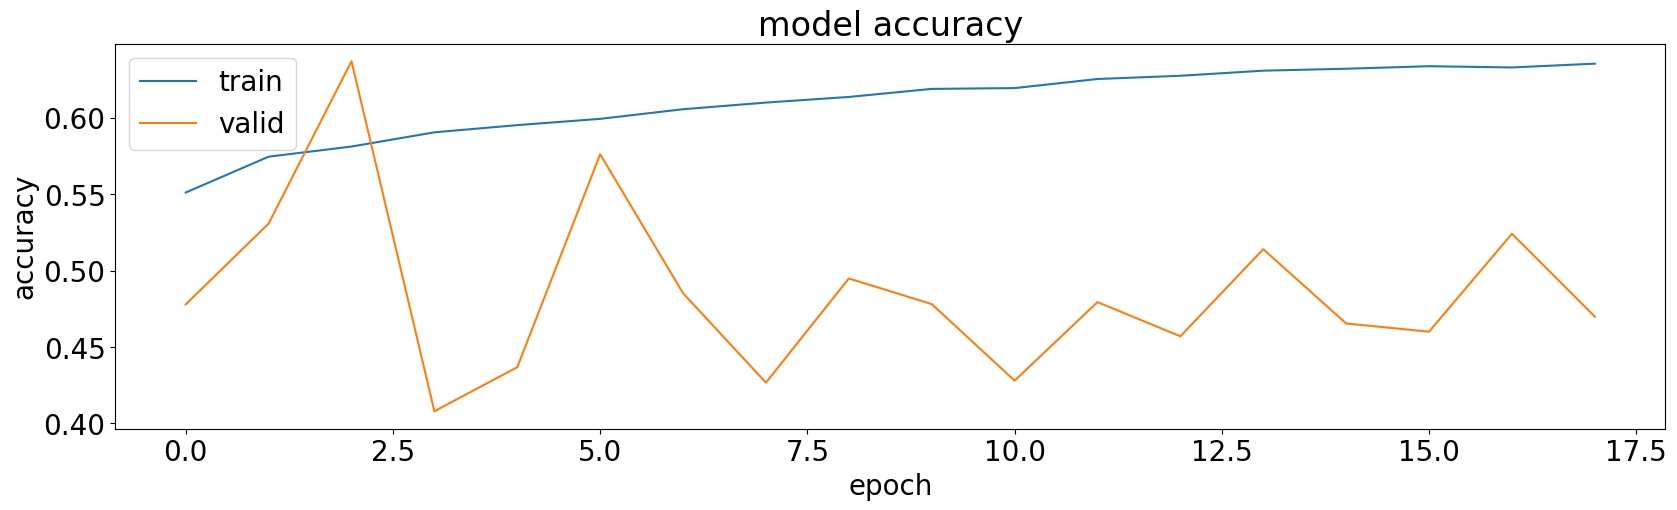

243/243 [==============================] - 7s 19ms/step


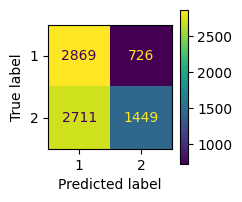

              precision    recall  f1-score   support

           1       0.51      0.80      0.63      3595
           2       0.67      0.35      0.46      4160

    accuracy                           0.56      7755
   macro avg       0.59      0.57      0.54      7755
weighted avg       0.60      0.56      0.54      7755

146/146 [==============================] - 3s 20ms/step
| 42        | 0.637     | 7.874     | 1.441     | 0.5334    | 0.1685    | 1.791     | 6.057     | 2.226     | 3.029     |
0


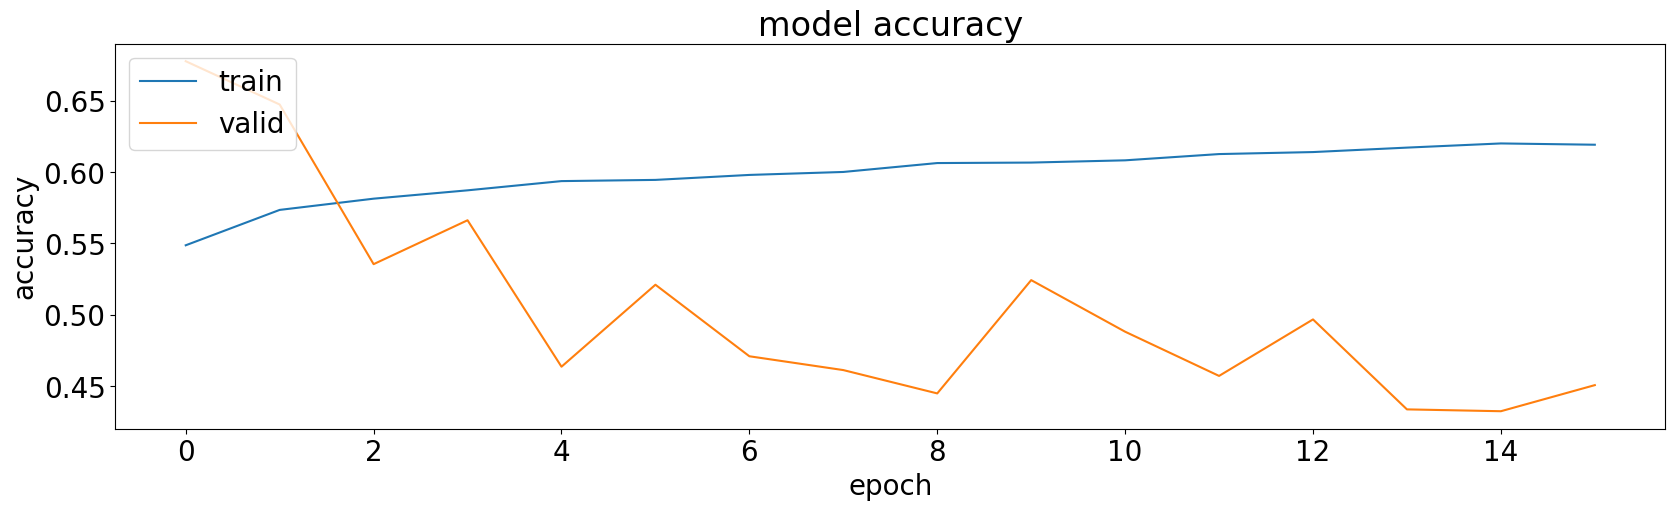

243/243 [==============================] - 3s 10ms/step


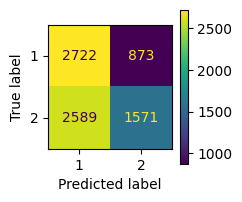

              precision    recall  f1-score   support

           1       0.51      0.76      0.61      3595
           2       0.64      0.38      0.48      4160

    accuracy                           0.55      7755
   macro avg       0.58      0.57      0.54      7755
weighted avg       0.58      0.55      0.54      7755

146/146 [==============================] - 2s 11ms/step
| 43        | 0.6776    | 7.582     | 1.433     | 0.6       | 0.04428   | 1.014     | 5.807     | 2.111     | 3.0       |
0


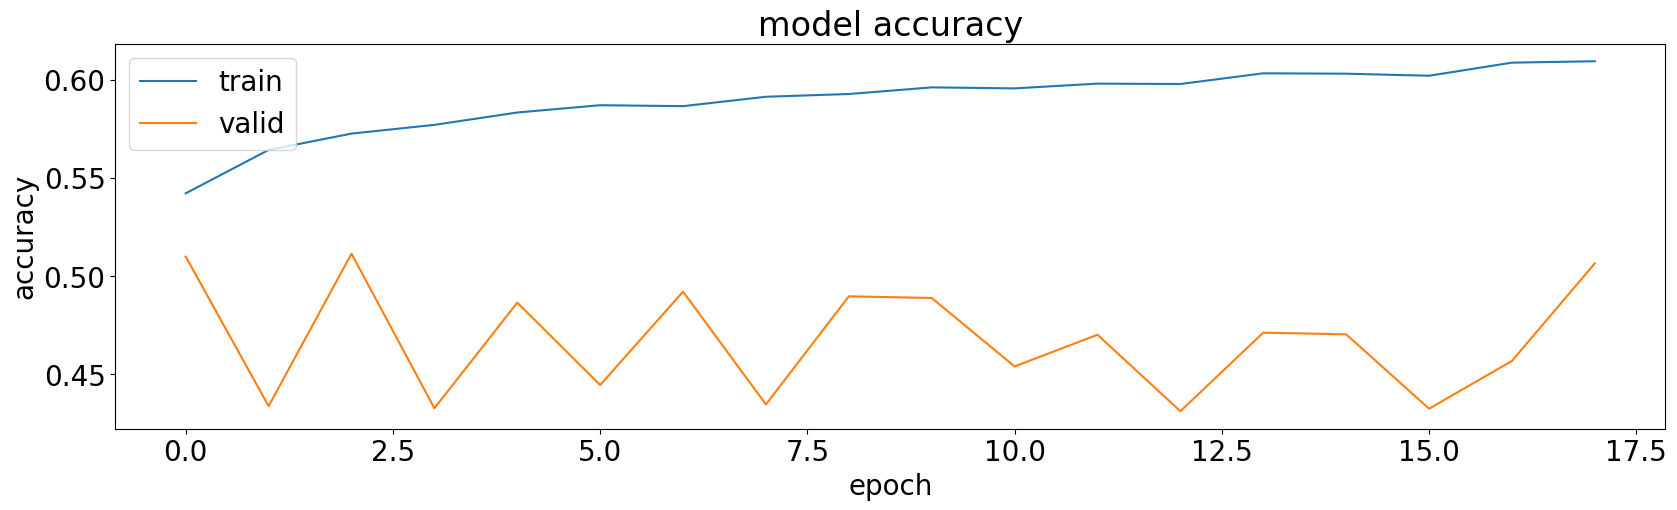

243/243 [==============================] - 3s 11ms/step


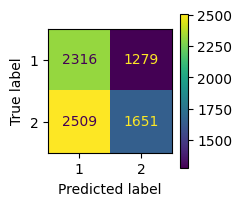

              precision    recall  f1-score   support

           1       0.48      0.64      0.55      3595
           2       0.56      0.40      0.47      4160

    accuracy                           0.51      7755
   macro avg       0.52      0.52      0.51      7755
weighted avg       0.52      0.51      0.50      7755

146/146 [==============================] - 2s 11ms/step
| 44        | 0.5114    | 8.109     | 1.491     | 0.6       | 0.0       | 1.056     | 5.435     | 2.367     | 3.0       |
0


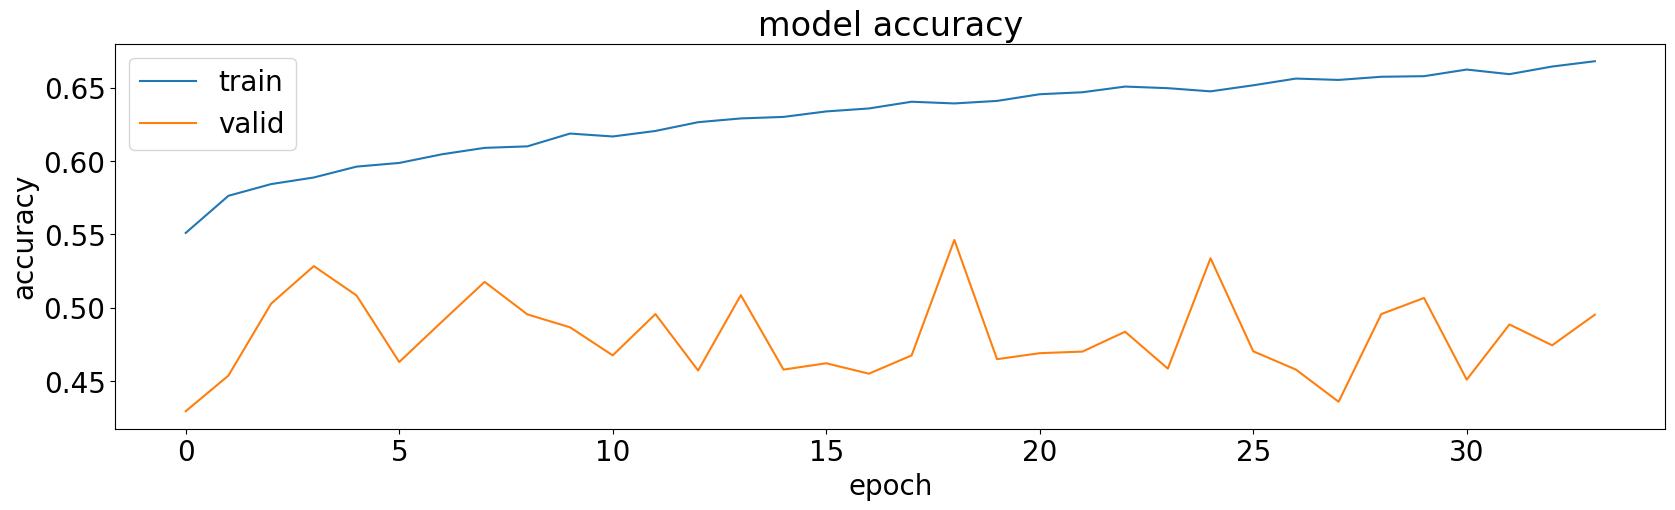

243/243 [==============================] - 3s 12ms/step


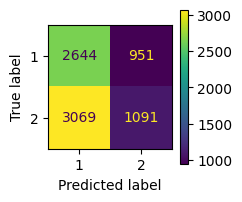

              precision    recall  f1-score   support

           1       0.46      0.74      0.57      3595
           2       0.53      0.26      0.35      4160

    accuracy                           0.48      7755
   macro avg       0.50      0.50      0.46      7755
weighted avg       0.50      0.48      0.45      7755

146/146 [==============================] - 1s 9ms/step
| 45        | 0.5462    | 7.292     | 1.356     | 0.5788    | 0.1234    | 1.235     | 6.147     | 1.976     | 3.0       |
1


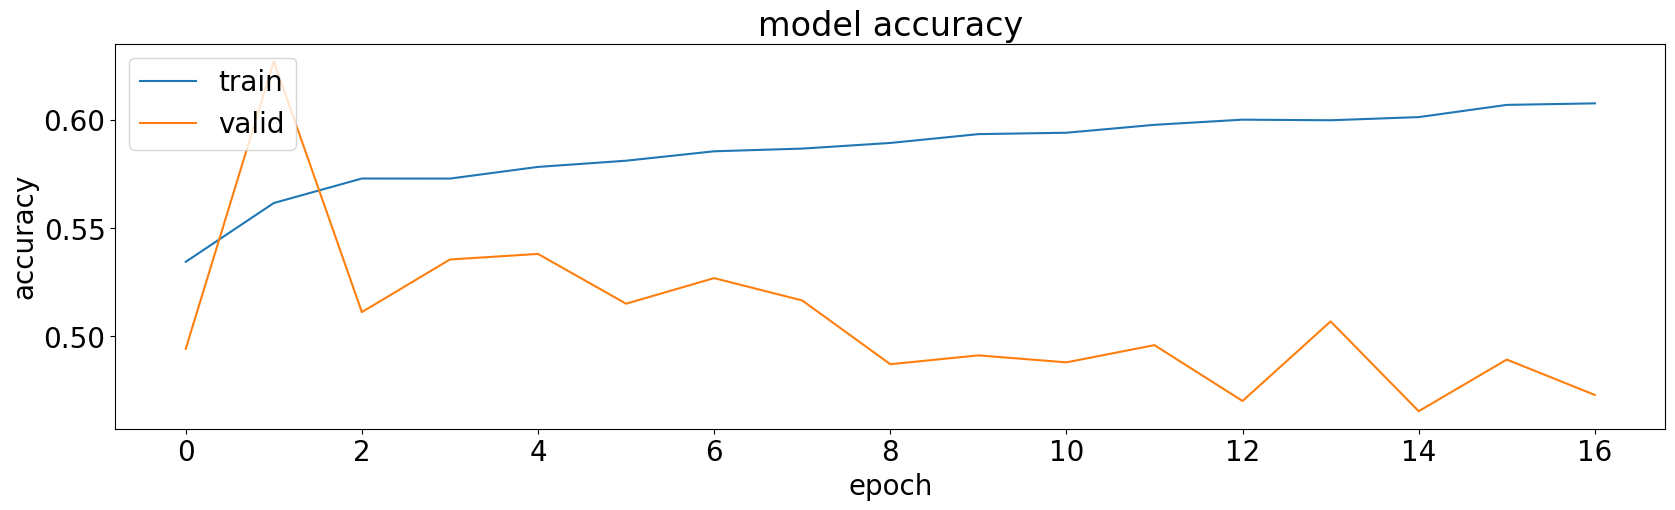

243/243 [==============================] - 3s 11ms/step


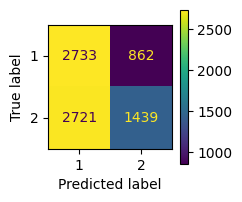

              precision    recall  f1-score   support

           1       0.50      0.76      0.60      3595
           2       0.63      0.35      0.45      4160

    accuracy                           0.54      7755
   macro avg       0.56      0.55      0.52      7755
weighted avg       0.57      0.54      0.52      7755

146/146 [==============================] - 2s 13ms/step
| 46        | 0.6271    | 6.415     | 1.526     | 0.3388    | 0.7642    | 1.023     | 5.945     | 2.086     | 4.377     |
1


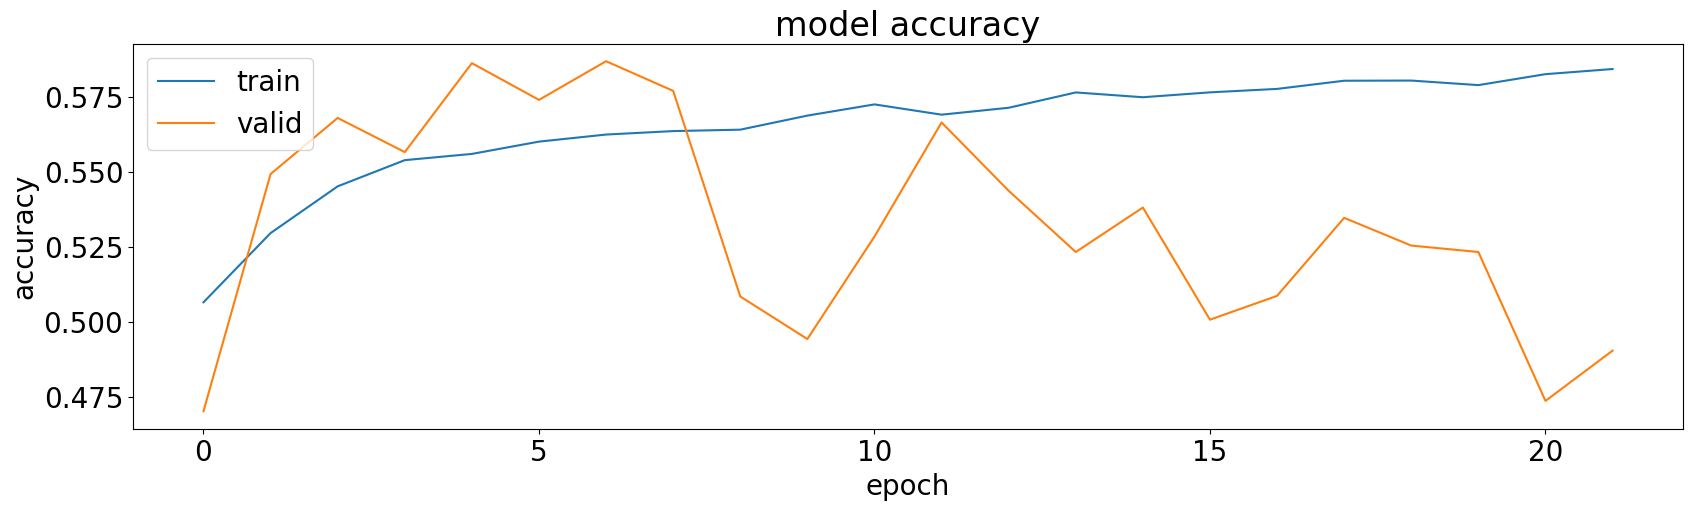

243/243 [==============================] - 9s 31ms/step


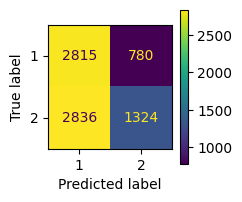

              precision    recall  f1-score   support

           1       0.50      0.78      0.61      3595
           2       0.63      0.32      0.42      4160

    accuracy                           0.53      7755
   macro avg       0.56      0.55      0.52      7755
weighted avg       0.57      0.53      0.51      7755

146/146 [==============================] - 4s 29ms/step
| 47        | 0.5869    | 8.696     | 1.847     | 0.398     | 0.899     | 3.178     | 6.652     | 2.378     | 3.516     |
1


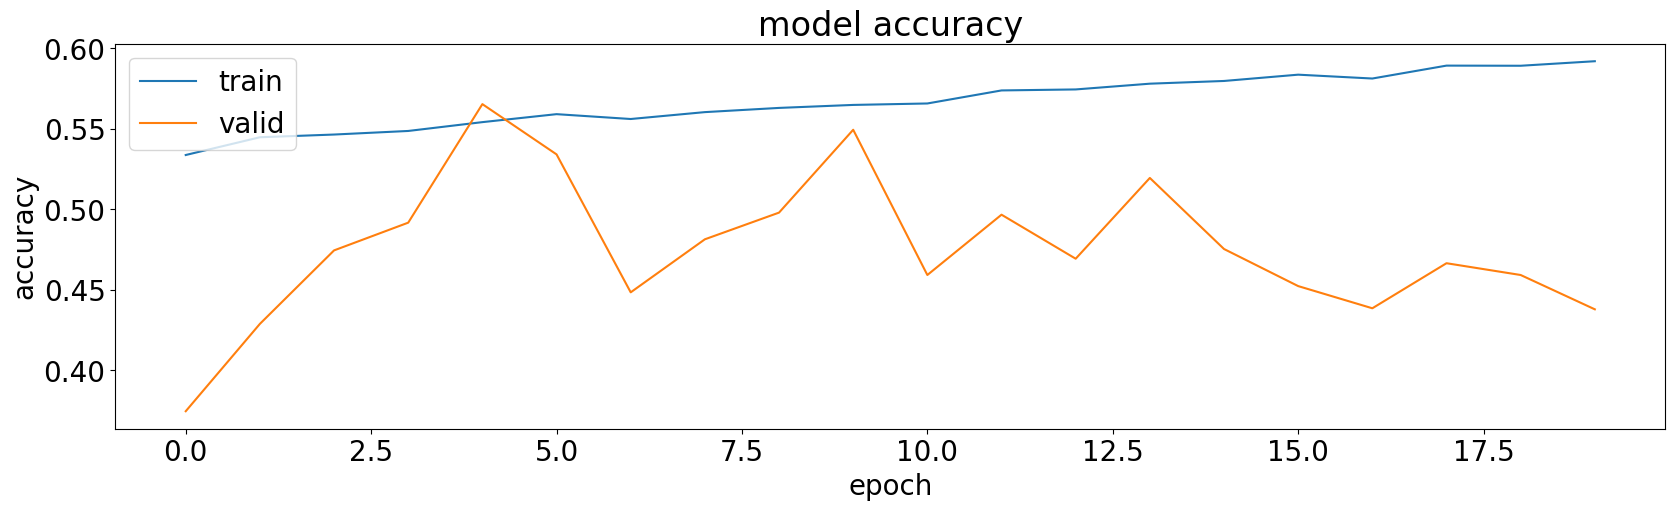

243/243 [==============================] - 11s 38ms/step


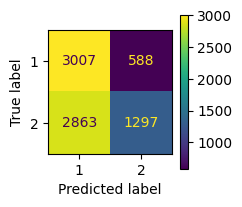

              precision    recall  f1-score   support

           1       0.51      0.84      0.64      3595
           2       0.69      0.31      0.43      4160

    accuracy                           0.55      7755
   macro avg       0.60      0.57      0.53      7755
weighted avg       0.61      0.55      0.52      7755

146/146 [==============================] - 6s 38ms/step
| 48        | 0.5652    | 7.329     | 3.464     | 0.4025    | 0.6875    | 3.766     | 6.908     | 4.705     | 5.346     |
1


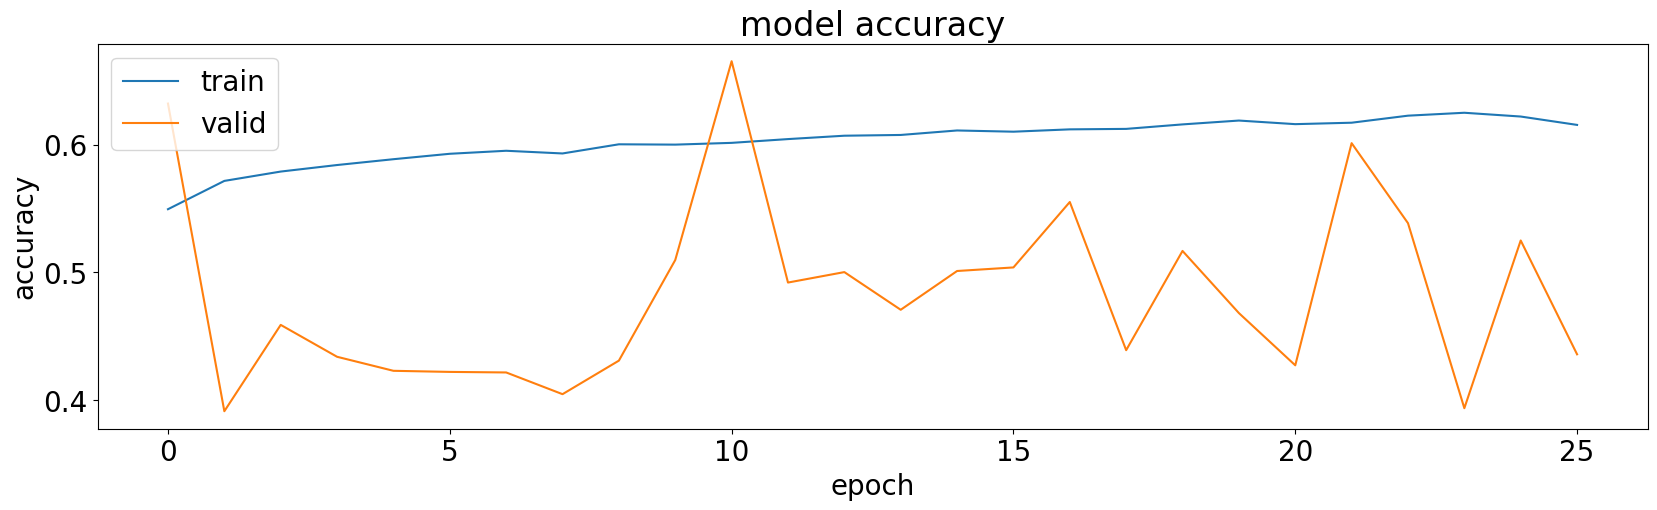

243/243 [==============================] - 3s 10ms/step


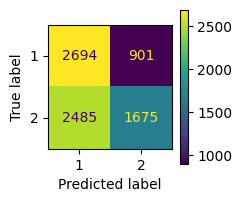

              precision    recall  f1-score   support

           1       0.52      0.75      0.61      3595
           2       0.65      0.40      0.50      4160

    accuracy                           0.56      7755
   macro avg       0.59      0.58      0.56      7755
weighted avg       0.59      0.56      0.55      7755

146/146 [==============================] - 2s 11ms/step
| 49        | 0.6652    | 7.982     | 1.049     | 0.345     | 0.9948    | 1.07      | 5.425     | 3.173     | 5.839     |
1


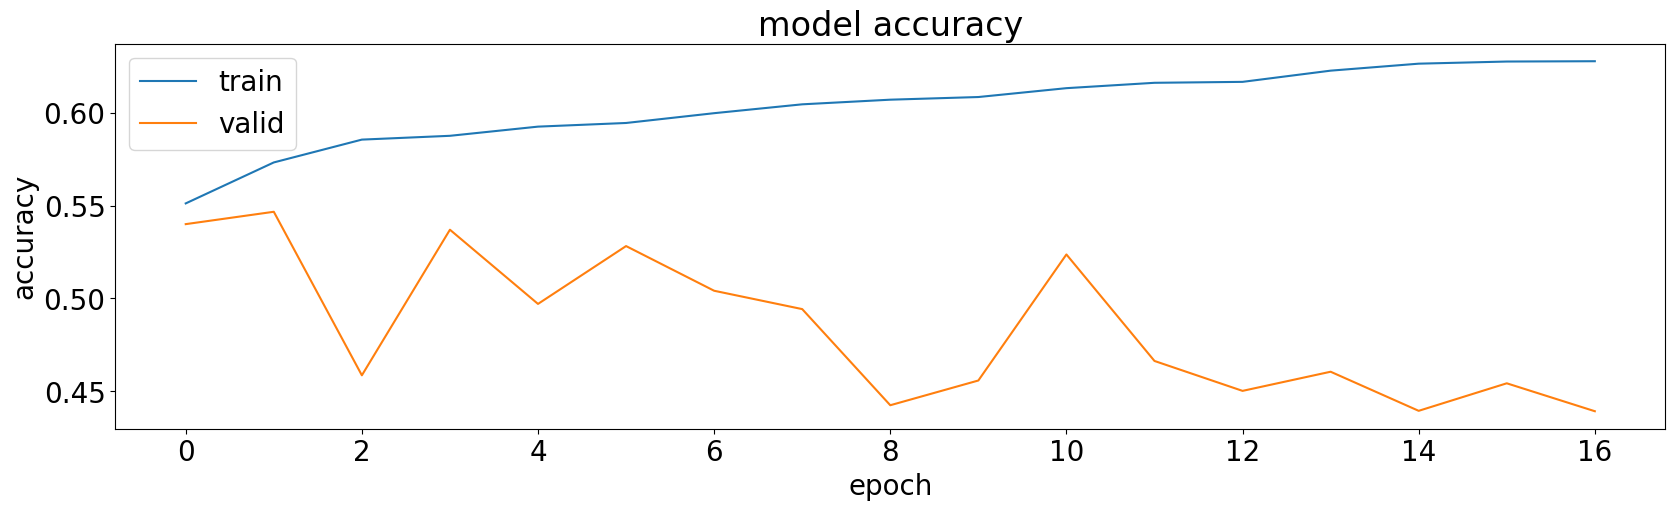

243/243 [==============================] - 3s 10ms/step


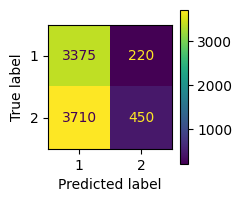

              precision    recall  f1-score   support

           1       0.48      0.94      0.63      3595
           2       0.67      0.11      0.19      4160

    accuracy                           0.49      7755
   macro avg       0.57      0.52      0.41      7755
weighted avg       0.58      0.49      0.39      7755

146/146 [==============================] - 2s 11ms/step
| 50        | 0.5467    | 7.49      | 1.0       | 0.5089    | 0.8926    | 1.05      | 6.191     | 3.179     | 5.202     |
0


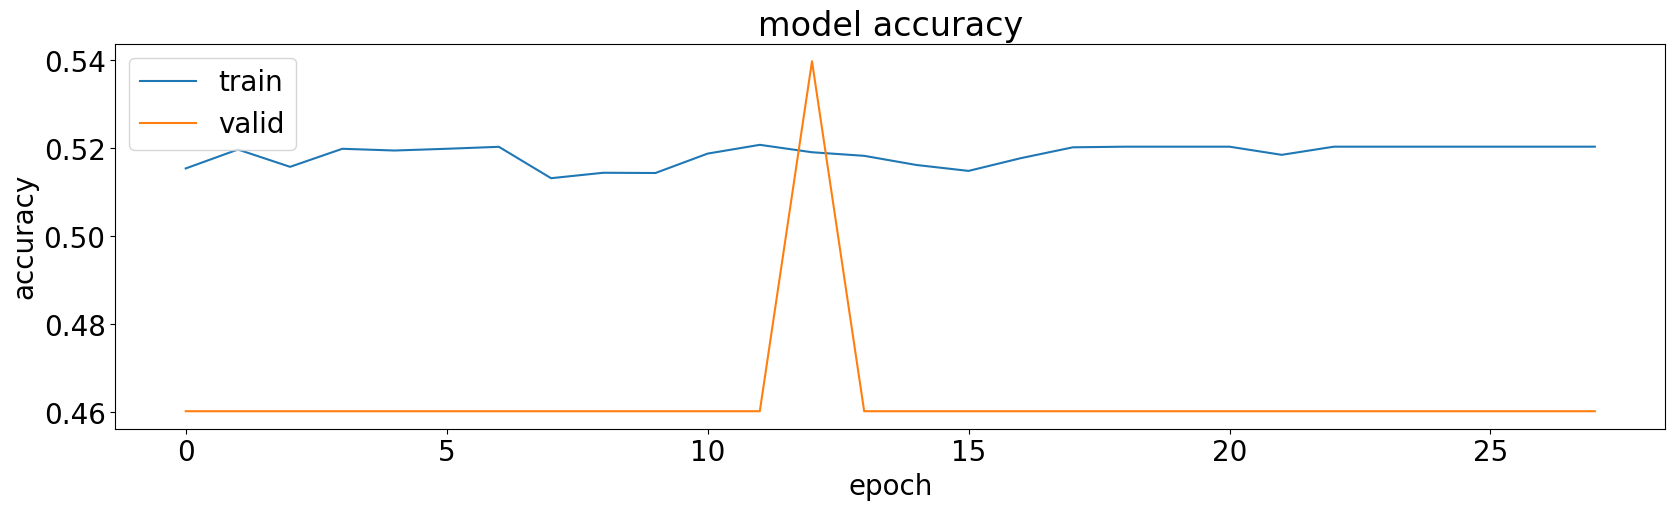

243/243 [==============================] - 9s 30ms/step


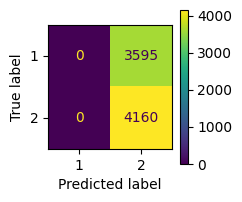

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3595
           2       0.54      1.00      0.70      4160

    accuracy                           0.54      7755
   macro avg       0.27      0.50      0.35      7755
weighted avg       0.29      0.54      0.37      7755

146/146 [==============================] - 4s 30ms/step
| 51        | 0.5398    | 7.688     | 2.3       | 0.4703    | 0.105     | 3.125     | 5.287     | 3.684     | 6.342     |
0


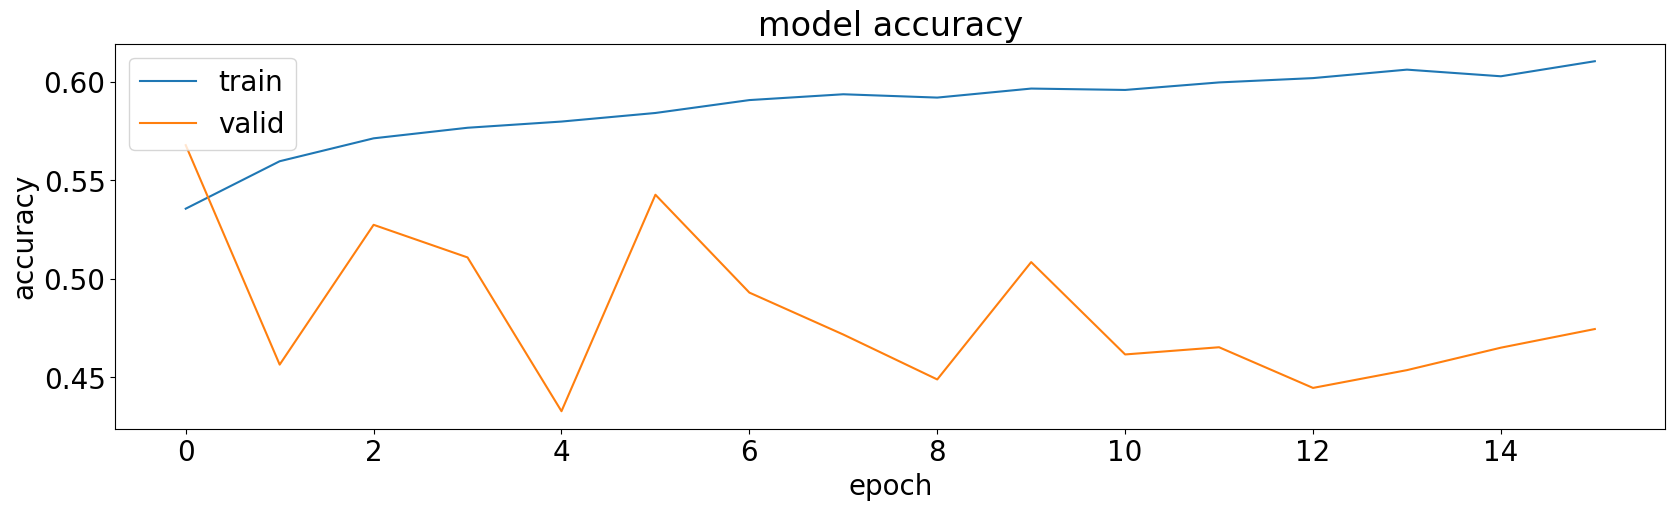

243/243 [==============================] - 3s 11ms/step


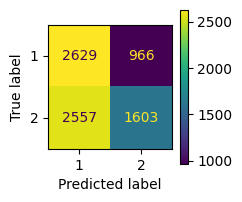

              precision    recall  f1-score   support

           1       0.51      0.73      0.60      3595
           2       0.62      0.39      0.48      4160

    accuracy                           0.55      7755
   macro avg       0.57      0.56      0.54      7755
weighted avg       0.57      0.55      0.53      7755

146/146 [==============================] - 2s 11ms/step
| 52        | 0.5677    | 8.695     | 1.908     | 0.3757    | 0.2209    | 1.045     | 5.855     | 2.055     | 6.223     |
1


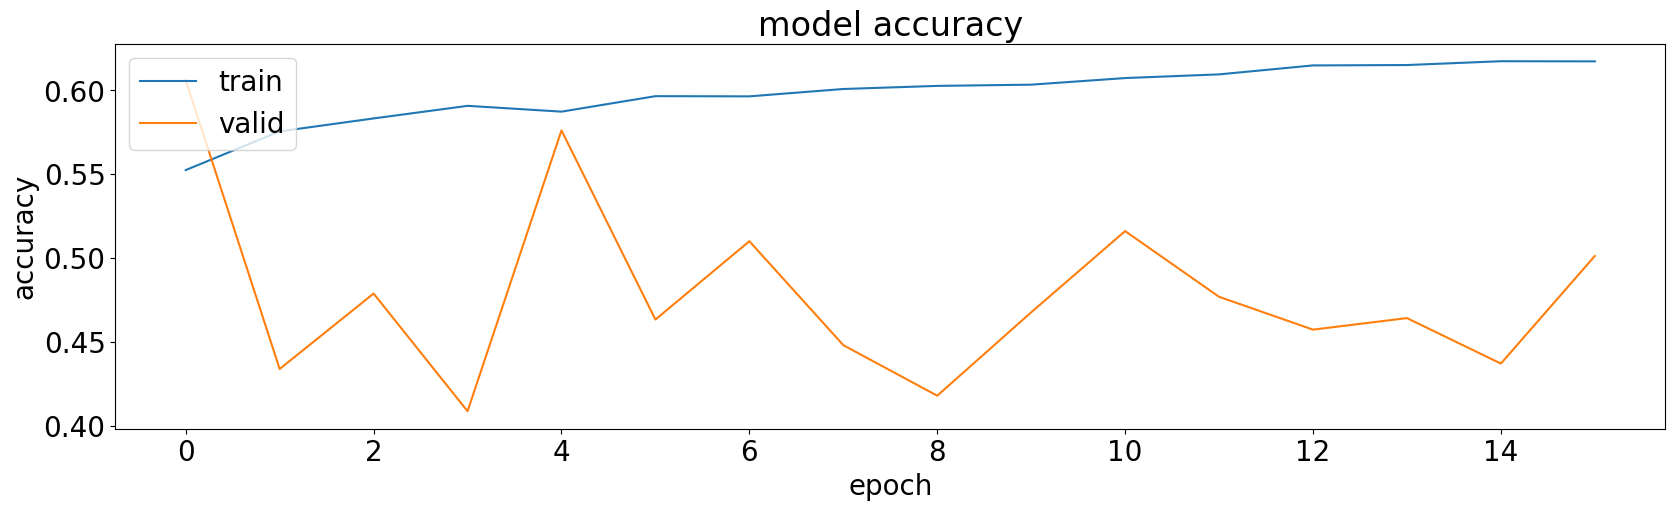

243/243 [==============================] - 3s 11ms/step


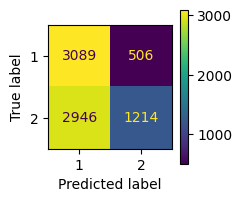

              precision    recall  f1-score   support

           1       0.51      0.86      0.64      3595
           2       0.71      0.29      0.41      4160

    accuracy                           0.55      7755
   macro avg       0.61      0.58      0.53      7755
weighted avg       0.62      0.55      0.52      7755

146/146 [==============================] - 1s 10ms/step
| 53        | 0.6058    | 7.294     | 1.077     | 0.5479    | 0.8403    | 1.434     | 5.968     | 2.732     | 4.574     |
0


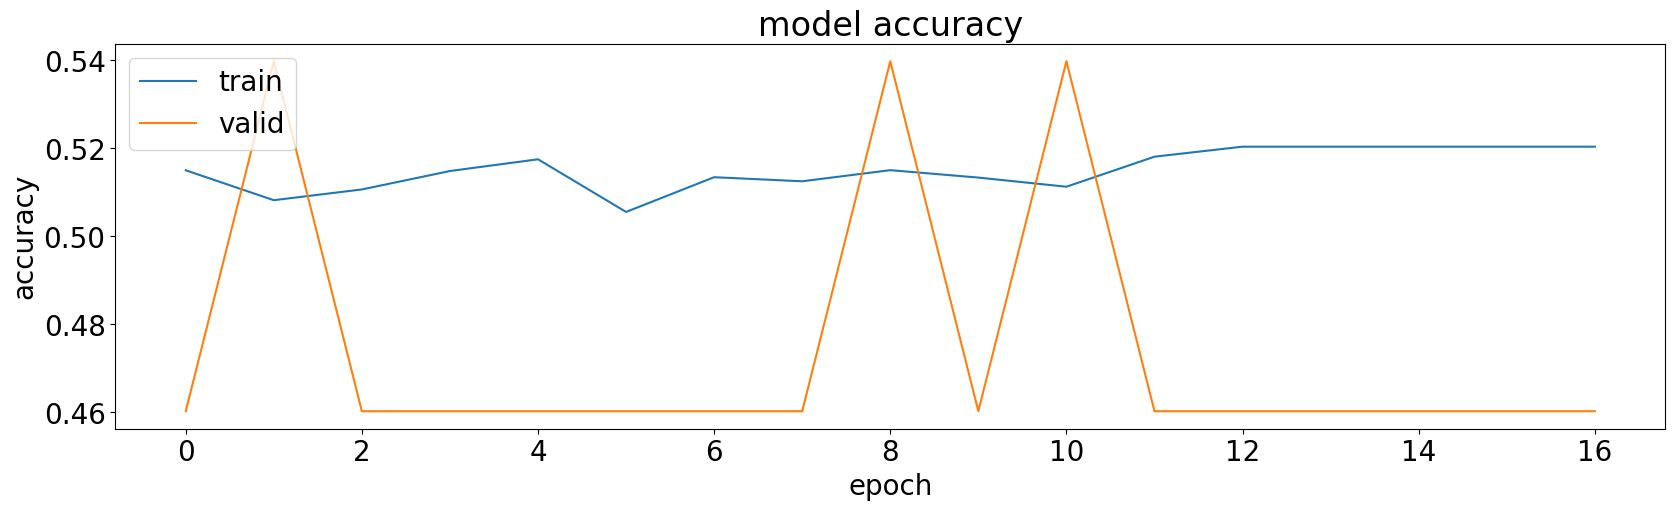

243/243 [==============================] - 4s 13ms/step


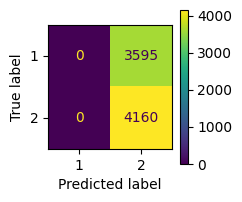

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3595
           2       0.54      1.00      0.70      4160

    accuracy                           0.54      7755
   macro avg       0.27      0.50      0.35      7755
weighted avg       0.29      0.54      0.37      7755

146/146 [==============================] - 2s 11ms/step
| 54        | 0.5398    | 7.799     | 1.917     | 0.3346    | 0.02101   | 1.073     | 6.762     | 0.2678    | 7.381     |
1


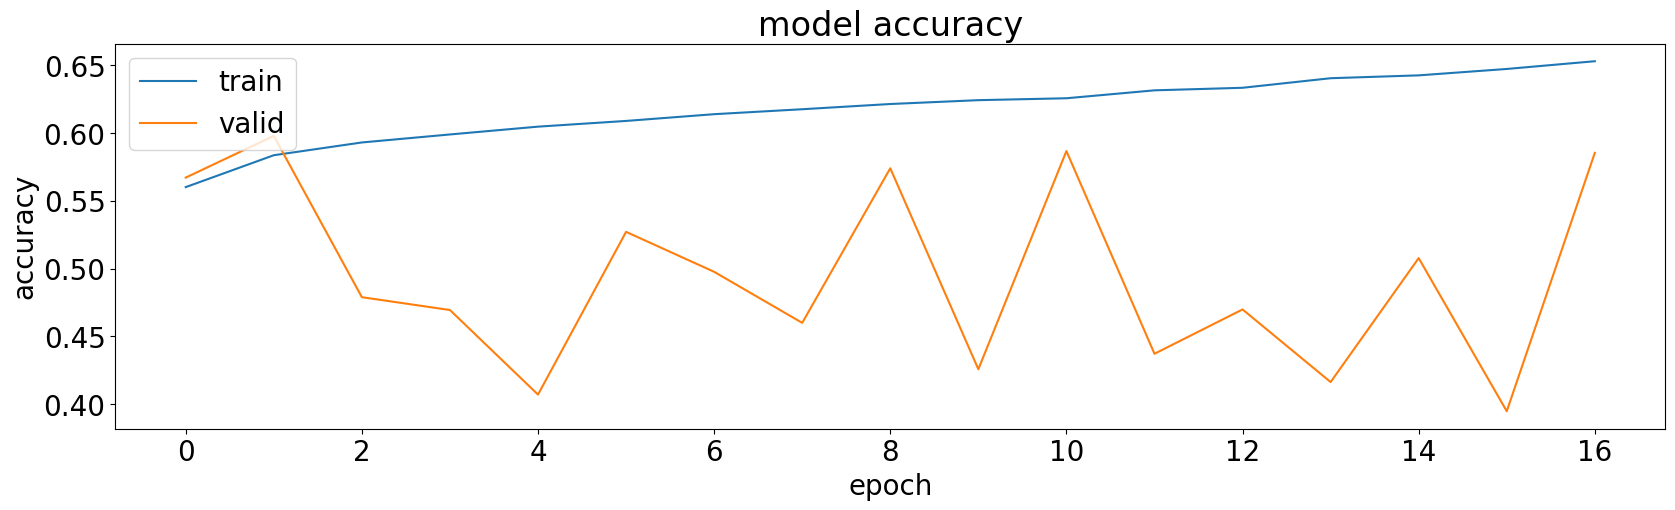

243/243 [==============================] - 3s 10ms/step


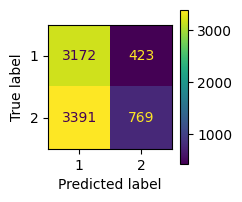

              precision    recall  f1-score   support

           1       0.48      0.88      0.62      3595
           2       0.65      0.18      0.29      4160

    accuracy                           0.51      7755
   macro avg       0.56      0.53      0.46      7755
weighted avg       0.57      0.51      0.44      7755

146/146 [==============================] - 1s 10ms/step
| 55        | 0.5978    | 7.046     | 1.312     | 0.3       | 1.0       | 1.023     | 6.37      | 2.718     | 5.017     |
0


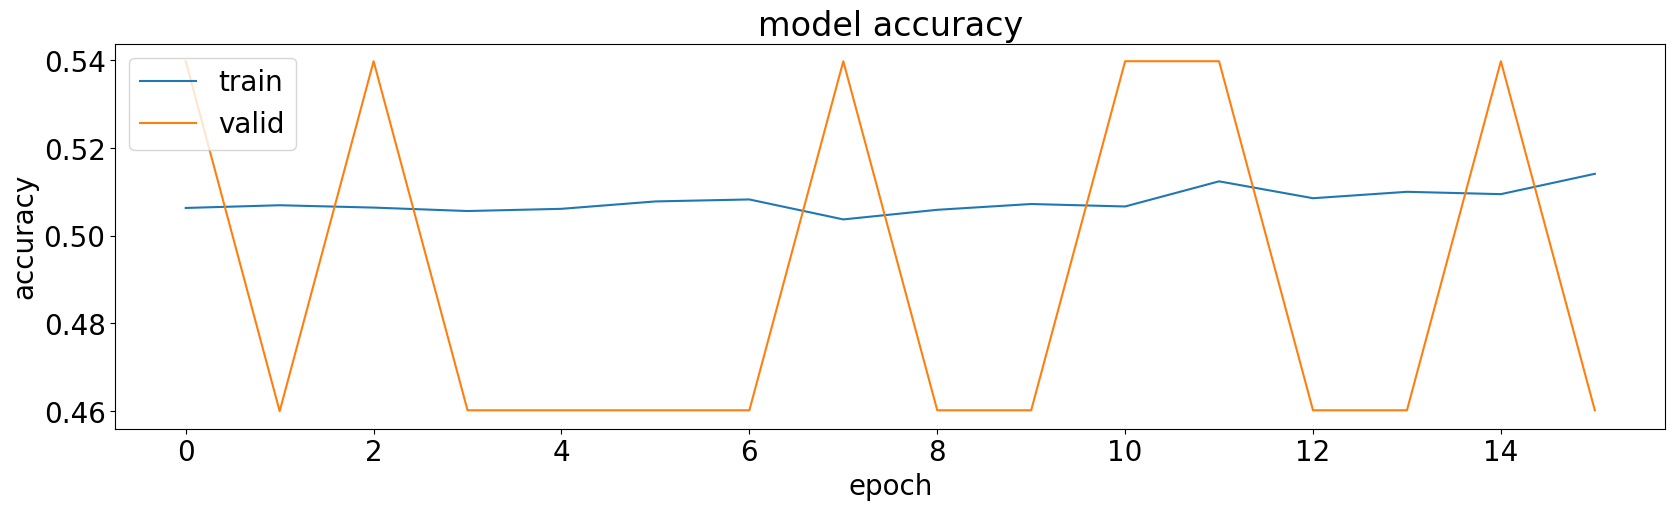

243/243 [==============================] - 6s 21ms/step


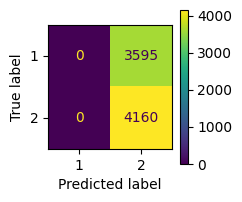

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3595
           2       0.54      1.00      0.70      4160

    accuracy                           0.54      7755
   macro avg       0.27      0.50      0.35      7755
weighted avg       0.29      0.54      0.37      7755

146/146 [==============================] - 3s 20ms/step
| 56        | 0.5398    | 8.363     | 1.819     | 0.415     | 0.3776    | 2.138     | 5.793     | 1.029     | 3.933     |
0


KeyboardInterrupt: ignored

In [39]:
pbounds = {'lstm_layers': (1, 4),
           'dense_layers': (1, 4),
           'units': (3, 8),
           'neurons_ini': (5, 7),
           'optimizer': (0, 5),
           'batch_size': (6, 9),
           'learning_rate': (0, 1),
           'dropout': (0.3, 0.6)
         }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1
)

optimizer.maximize(init_points=15, n_iter=85)

In [ ]:
model = load_model('/content/_pesos_lstm1.h5')

In [ ]:
y_pred = model.predict(x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = [1, 2]
y_pred = y_pred.idxmax(axis=1)
y_test = y_test.idxmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

plt.rcParams['figure.figsize']=(2,2)
plt.rcParams.update({'font.size': 10})

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()

In [ ]:
from sklearn.metrics import classification_report 
 
relatorio = classification_report(y_test, y_pred, target_names = ['1','2']) 
print(relatorio)

|   iter    |  target   | batch_... | dense_... | learni... | lstm_l... | neuron... | optimizer |   units   |
| 1         | 0.9851    | 7.251     | 3.161     | 0.0001144 | 1.907     | 5.294     | 0.4617    | 3.931     |
| 3         | 0.9851    | 6.082     | 3.011     | 0.4173    | 2.676     | 5.281     | 0.9905    | 7.004     |
| 2         | 0.9071    | 7.037     | 2.19      | 0.5388    | 2.258     | 6.37      | 1.022     | 7.391     |
| 4         | 0.9405    | 8.905     | 1.94      | 0.6923    | 3.629     | 6.789     | 0.4252    | 3.195     |
| 7         | 0.9851    | 6.841     | 3.368     | 0.1032    | 2.344     | 6.817     | 1.468     | 4.439     |
| 8         | 0.01859   | 6.39      | 1.058     | 0.6788    | 1.635     | 5.531     | 2.458     | 3.267     |
| 11        | 0.9851    | 8.71      | 1.412     | 0.1393    | 3.422     | 5.795     | 0.8268    | 7.638     |
| 13        | 0.9182    | 6.81      | 3.688     | 0.4281    | 3.895     | 6.327     | 3.108     | 3.574     |
